In [26]:
import numpy as np
import mnist
from tensorflow import keras

import sys
import os
module_path = os.path.abspath(os.path.join('..'))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import accuracy_score
font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)
font_small = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 8, weight = 1000)

num_filters = 8
filter_size = 3
pool_size = 2

# Build the model.
def get_model(X, y):
    model_init = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(10, activation='softmax'),
    ])

    # Compile the model.
    model_init.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    # Train the model.
    history = model_init.fit(
      X,
      to_categorical(y),
      epochs=3
    )
    return history, model_init

def get_model_help(X, y):
    model_init = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(28, 28, 1)),
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(2, activation='softmax'),
    ])

    # Compile the model.
    model_init.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    # Train the model.
    history = model_init.fit(
      X,
      to_categorical(y),
      epochs=3
    )
    return history, model_init


def get_helping_classifier(X_train, y_train, X_val, y_val):
    new_X = X_val
    _ , model_full = get_model(X_train, y_train)
    y_pred = np.argmax(model_full.predict(X_val), axis=1)
    new_y = y_pred != y_val
    history, model_help = get_model_help(new_X,new_y)
    score = np.mean(history.history['accuracy'])
    return model_help, score


def get_ensemble_model(X_train_full, y_train_full):
    kf = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)

    models = []
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        model, score = get_helping_classifier(X_train_full[train_index], y_train_full[train_index], X_train_full[val_index], y_train_full[val_index])
        models.append((model, score ))
    return models

def make_ensemble_classification(X_test, ensemble):
    y_pred = []
    for e in ensemble: 
        m = e[0]
        s = e[1]
        y_pred_temp = np.argmax(m.predict(X_test), axis=1)
        y_pred.append((s * (y_pred_temp + 1)) -1)
    y_pred = np.array(y_pred)
    y_pred_sum = y_pred.sum(axis = 0)
    idx_true = np.where(y_pred_sum > 0)[0]
    
    y_pred = y_pred.mean(axis = 0)
    y_pred = np.round(y_pred).astype(int)
    
    y_pred[idx_true] = 1
    return y_pred

def filter_test_set_ensemble(X_test, y_test, ensemble):
    y_pred = make_ensemble_classification(X_test, ensemble)
    to_del = np.where(y_pred == 1)[0]
    X_test_new = np.delete(X_test,to_del,0)
    y_test_new = np.delete(y_test,to_del,0)
    return X_test_new, y_test_new, to_del

def plot_cm(m, X_test, y_test, class_names, color_index = 2):
    y_pred = np.argmax(m.predict(X_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    colors = ["#F94144", "#F3722C", '#F8961E', '#F9C74F','#90BE6D', '#43AA8B','#577590']

    font = FontProperties(fname = module_path + '/src/visualization/CharterRegular.ttf', size = 10, weight = 1000)

    colors_2 = ['#FFFFFF', colors[color_index]]
    cmap_name = 'my colormap'
    font_small = FontProperties(fname =  module_path + '/src/visualization/CharterRegular.ttf', size = 6, weight = 1000)

    cm_map = LinearSegmentedColormap.from_list(cmap_name, colors_2)


    f, ax = plt.subplots(1,1) # 1 x 1 array , can also be any other size
    f.set_size_inches(5, 5)

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm, annot=True,
                fmt='.2%', cmap=cm_map, xticklabels=class_names,yticklabels=class_names )
    cbar = ax.collections[0].colorbar
    for label in ax.get_yticklabels() :
        label.set_fontproperties(font_small)
    for label in ax.get_xticklabels() :
        label.set_fontproperties(font_small)
    ax.set_ylabel('True Label', fontproperties = font)
    ax.set_xlabel('Predicted Label', fontproperties = font)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)

    for child in ax.get_children():
        if isinstance(child, matplotlib.text.Text):
            child.set_fontproperties(font)
    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_fontproperties(font_small)
        
    plt.show()
    
def plot_sample(dataset, sample):
    image = dataset[sample]

    # plot the sample
    fig = plt.figure
    plt.imshow(image, cmap='gray')
    plt.show()

In [36]:
X_train_full = mnist.train_images()
y_train_full = mnist.train_labels()
X_test = mnist.test_images()
y_test = mnist.test_labels()

# Normalize the images.
X_train_full = (X_train_full / 255) - 0.5
X_test = (X_test / 255) - 0.5

# Reshape the images.
X_train_full = np.expand_dims(X_train_full, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [39]:
_ , model_full = get_model(X_train_full, y_train_full)
model_ensemble = get_ensemble_model(X_train_full, y_train_full)

Epoch 1/3
1875/1875 [==============================] - 17s 9ms/step - loss: 0.5908 - accuracy: 0.8294
Epoch 2/3
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1976 - accuracy: 0.9446
Epoch 3/3
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1530 - accuracy: 0.9560
Epoch 1/3
1250/1250 [==============================] - 14s 10ms/step - loss: 0.6749 - accuracy: 0.8008
Epoch 2/3
1250/1250 [==============================] - 16s 13ms/step - loss: 0.2368 - accuracy: 0.9319
Epoch 3/3
1250/1250 [==============================] - 19s 15ms/step - loss: 0.1638 - accuracy: 0.9518
Epoch 1/3
625/625 [==============================] - 5s 7ms/step - loss: 0.2370 - accuracy: 0.9283
Epoch 2/3
625/625 [==============================] - 4s 7ms/step - loss: 0.1922 - accuracy: 0.9487
Epoch 3/3
625/625 [==============================] - 6s 9ms/step - loss: 0.1919 - accuracy: 0.9481
Epoch 1/3
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6785 - a

In [41]:
# Filtering the training set, then re-training
X_train_full, y_train_full, del_idx_train = filter_test_set_ensemble(X_test, y_test, model_ensemble)

In [46]:
_ , model_full_2 = get_model(X_train_full, y_train_full)
model_ensemble_2 = get_ensemble_model(X_train_full, y_train_full)

Epoch 1/3
282/282 [==============================] - 3s 8ms/step - loss: 1.1676 - accuracy: 0.6710
Epoch 2/3
282/282 [==============================] - 2s 8ms/step - loss: 0.3241 - accuracy: 0.9014
Epoch 3/3
282/282 [==============================] - 2s 8ms/step - loss: 0.2780 - accuracy: 0.9186
Epoch 1/3
188/188 [==============================] - 2s 8ms/step - loss: 1.2973 - accuracy: 0.6525
Epoch 2/3
188/188 [==============================] - 1s 8ms/step - loss: 0.2943 - accuracy: 0.9140
Epoch 3/3
188/188 [==============================] - 1s 8ms/step - loss: 0.2376 - accuracy: 0.9319
Epoch 1/3
94/94 [==============================] - 1s 8ms/step - loss: 0.4149 - accuracy: 0.8648
Epoch 2/3
94/94 [==============================] - 1s 8ms/step - loss: 0.3625 - accuracy: 0.8765
Epoch 3/3
94/94 [==============================] - 1s 9ms/step - loss: 0.3489 - accuracy: 0.8764
Epoch 1/3
188/188 [==============================] - 2s 9ms/step - loss: 1.5099 - accuracy: 0.5980
Epoch 2/3
188/18

Accuracy score:  0.8737


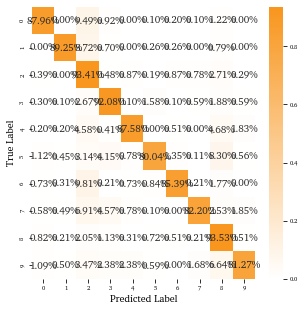

Accuracy score:  0.9392019562076248


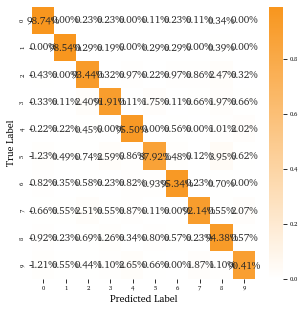

Accuracy score:  0.9300878070467934


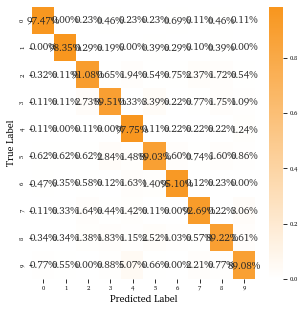

Accuracy score:  0.8888194878201124


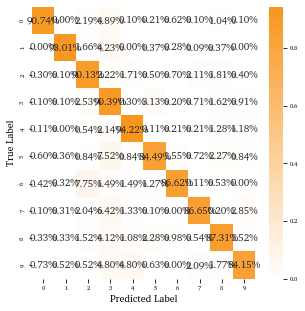

In [47]:
class_names = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9']
X_test_2, y_test_2, del_idx_test = filter_test_set_ensemble(X_test, y_test, model_ensemble)
plot_cm(model_full, X_test, y_test, class_names)
plot_cm(model_full, X_test_2, y_test_2, class_names)

X_test_3, y_test_3, del_idx_test = filter_test_set_ensemble(X_test, y_test, model_ensemble_2)
plot_cm(model_full_2, X_test_2, y_test_2, class_names)
plot_cm(model_full_2, X_test_3, y_test_3, class_names)

Accuracy score:  0.8737


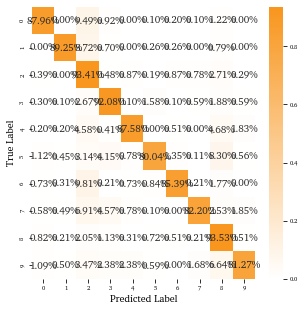

Accuracy score:  0.9392019562076248


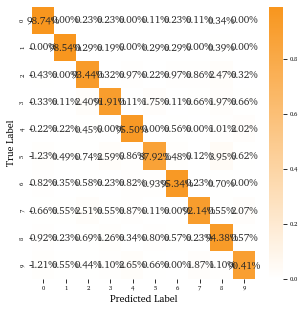

Accuracy score:  0.9300878070467934


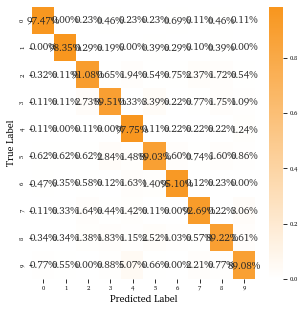

Accuracy score:  0.8888194878201124


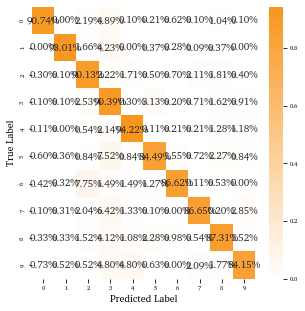

In [48]:
plot_cm(model_full, X_test, y_test, class_names)
plot_cm(model_full, X_test_2, y_test_2, class_names)

plot_cm(model_full_2, X_test_2, y_test_2, class_names)
plot_cm(model_full_2, X_test_3, y_test_3, class_names)

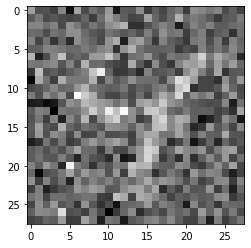

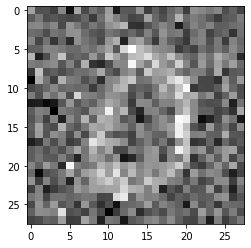

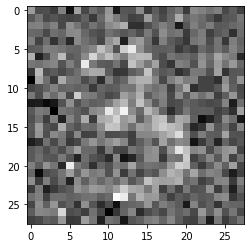

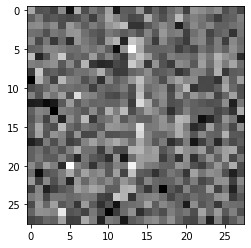

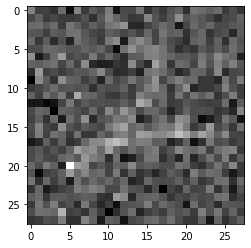

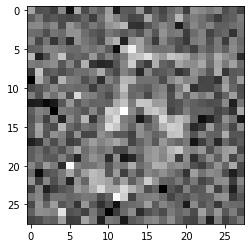

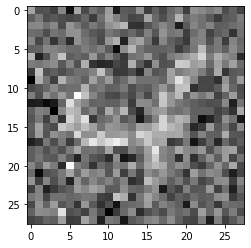

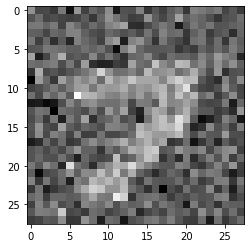

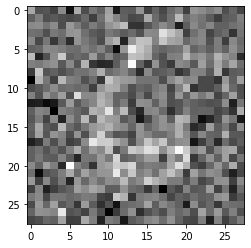

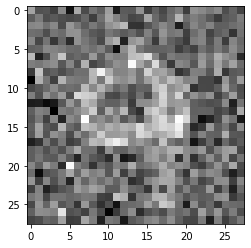

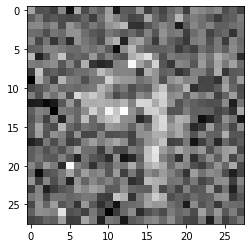

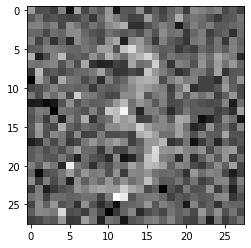

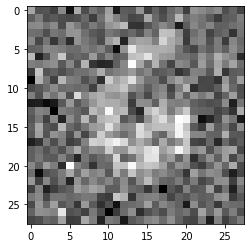

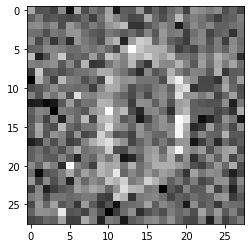

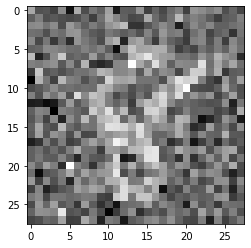

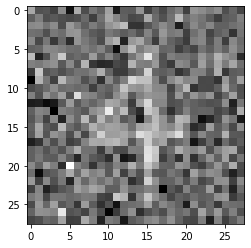

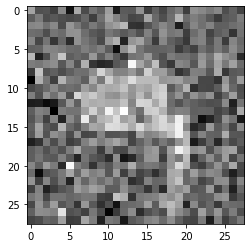

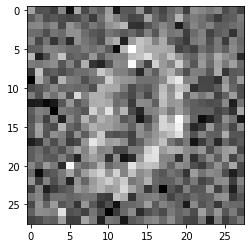

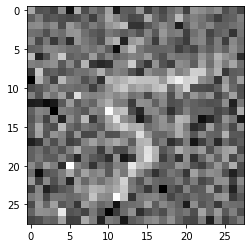

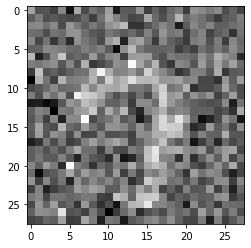

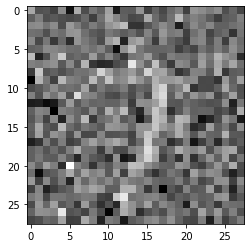

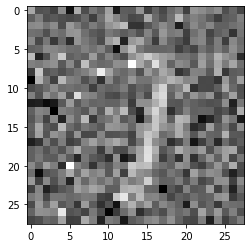

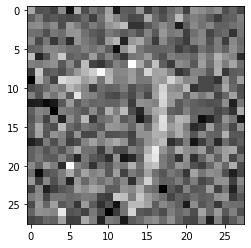

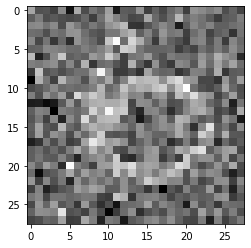

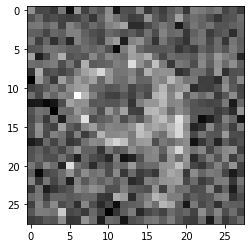

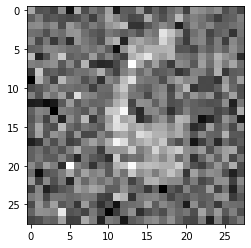

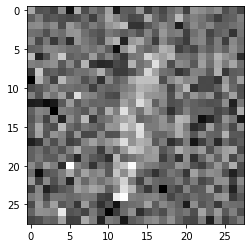

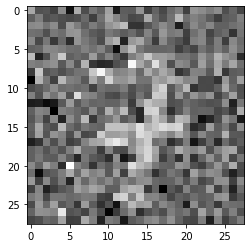

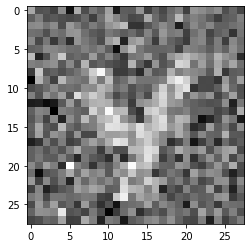

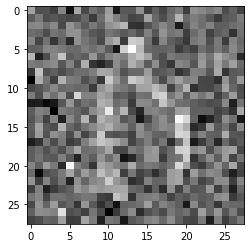

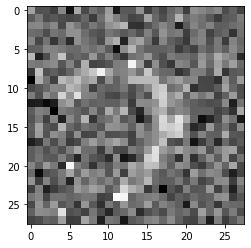

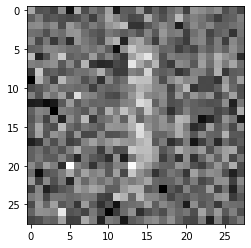

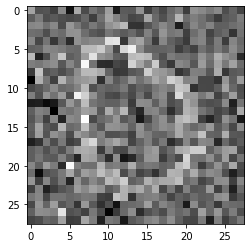

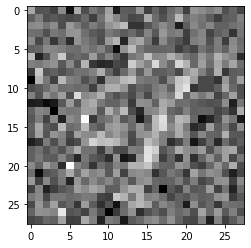

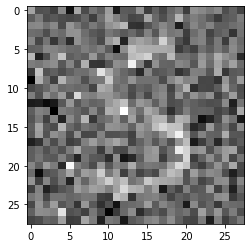

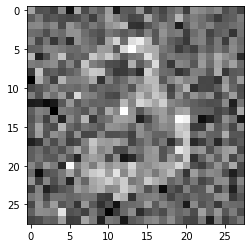

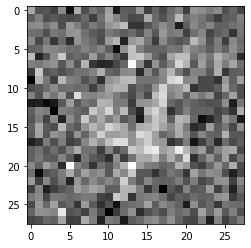

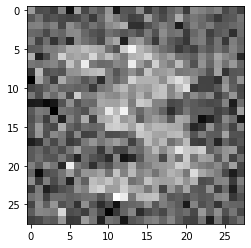

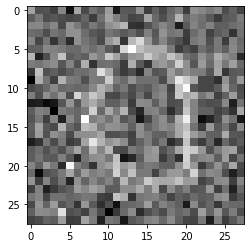

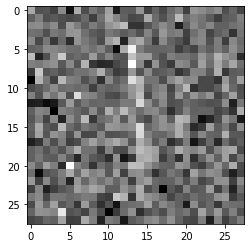

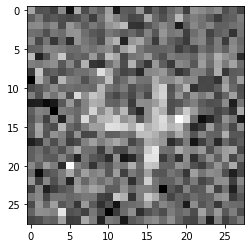

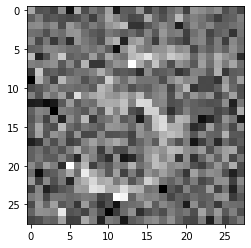

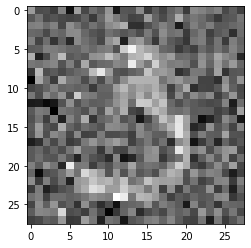

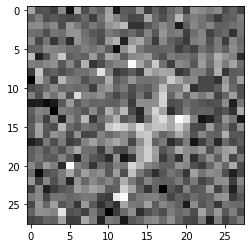

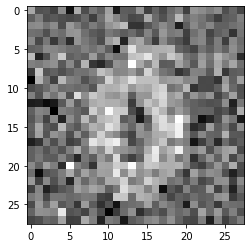

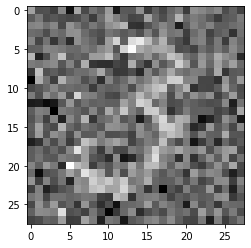

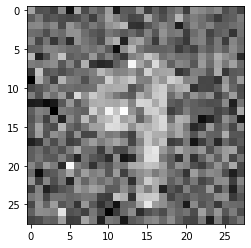

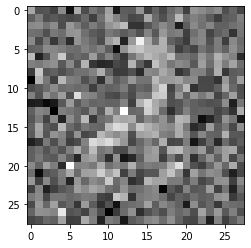

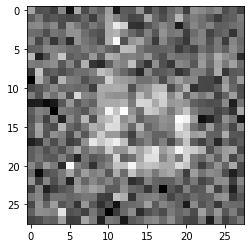

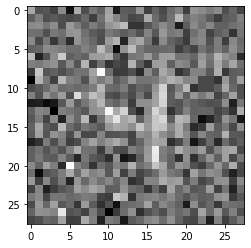

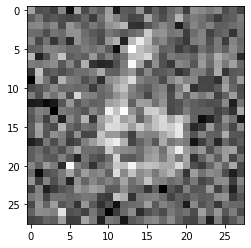

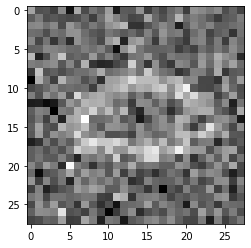

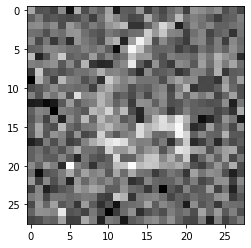

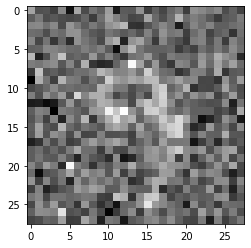

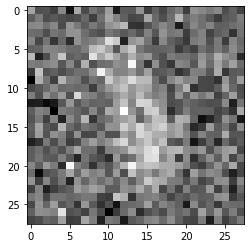

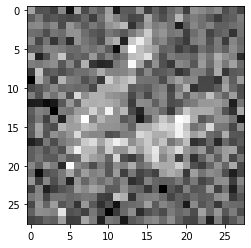

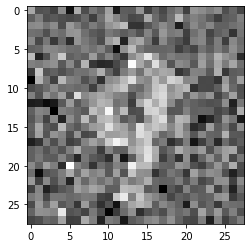

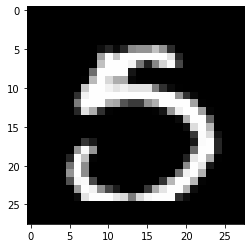

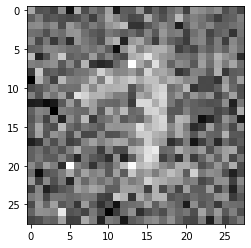

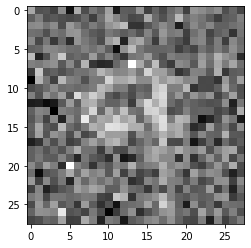

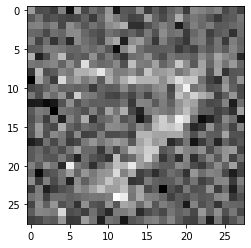

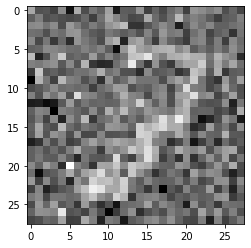

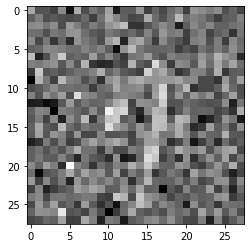

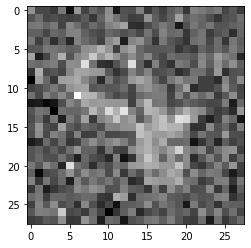

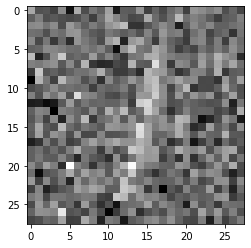

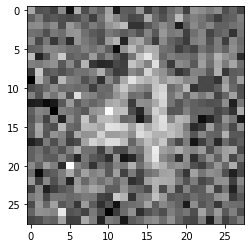

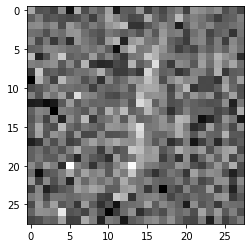

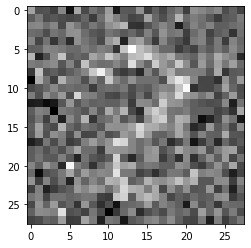

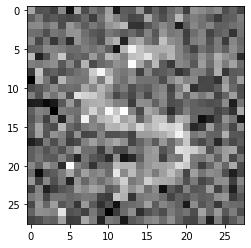

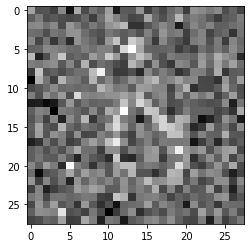

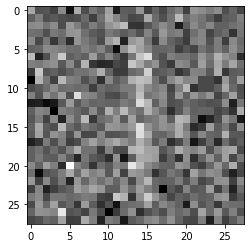

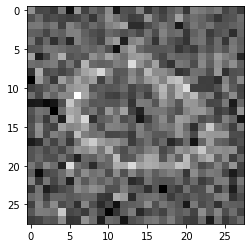

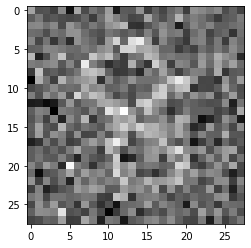

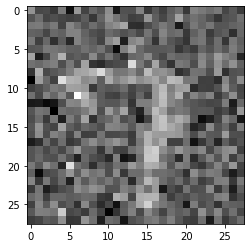

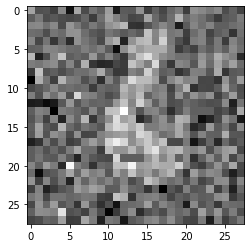

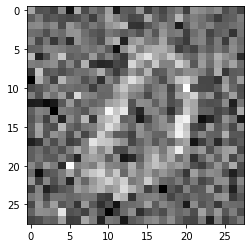

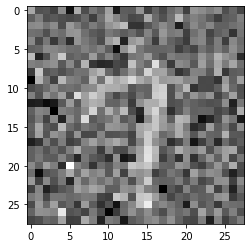

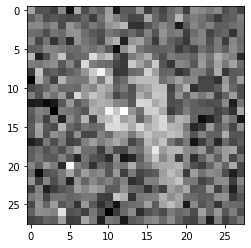

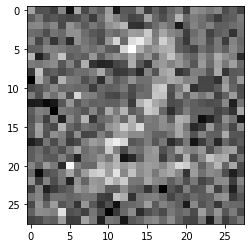

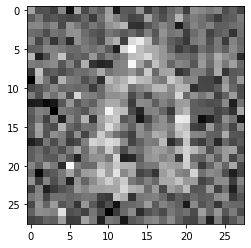

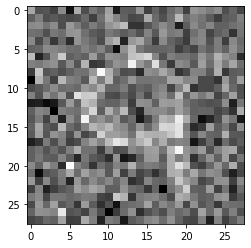

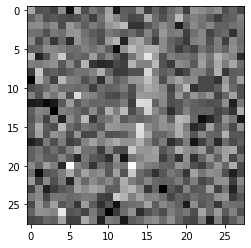

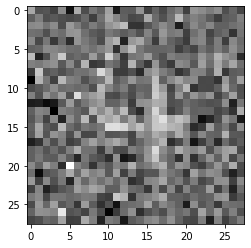

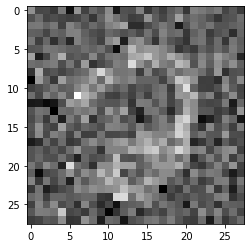

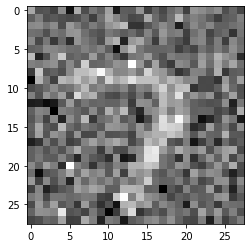

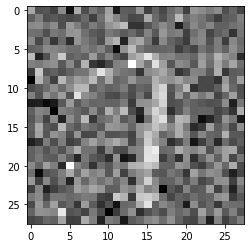

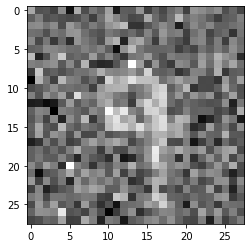

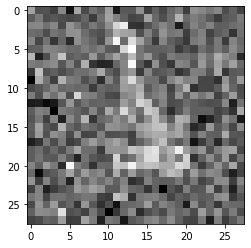

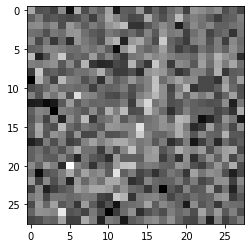

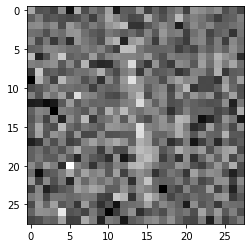

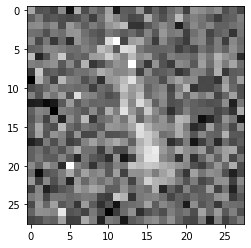

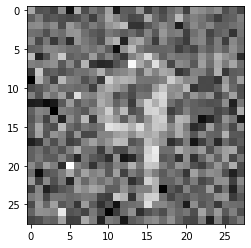

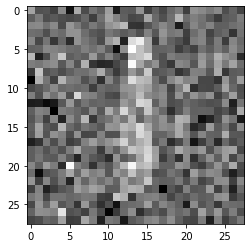

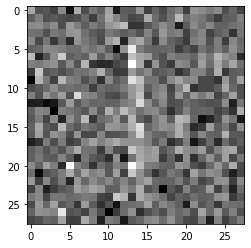

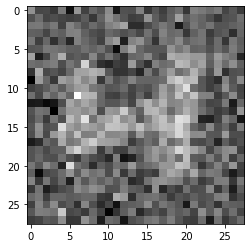

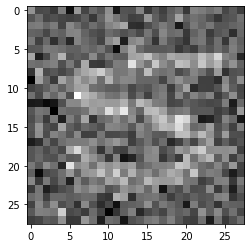

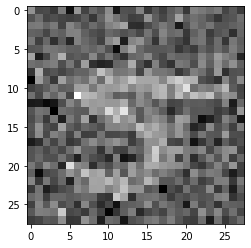

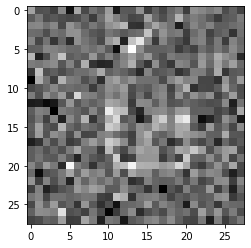

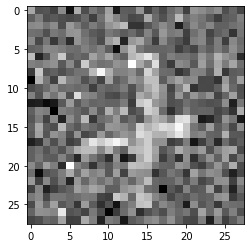

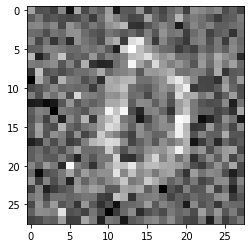

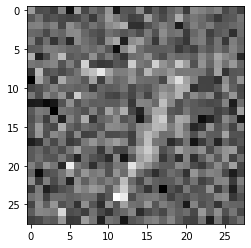

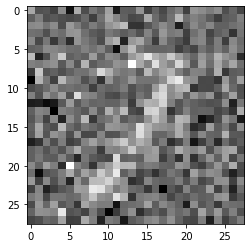

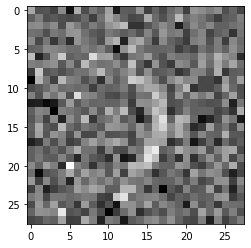

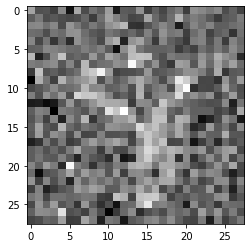

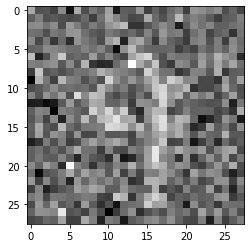

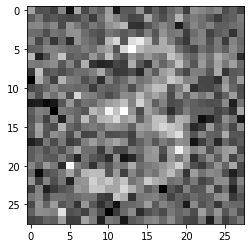

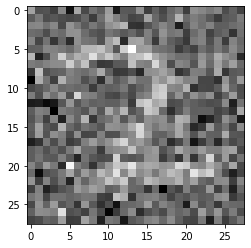

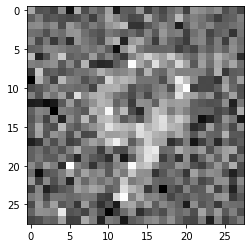

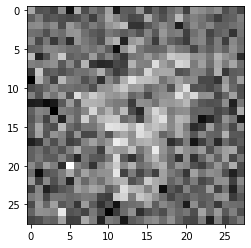

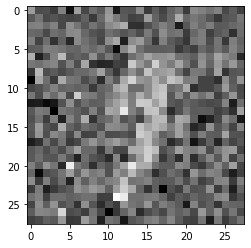

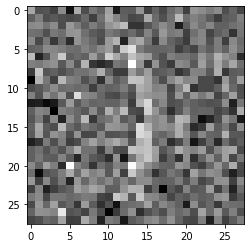

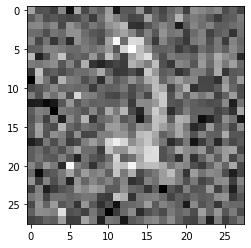

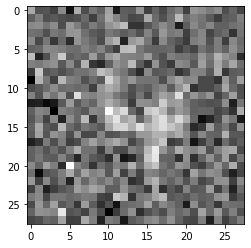

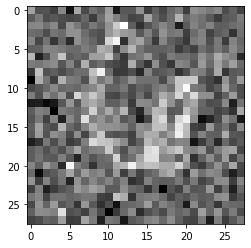

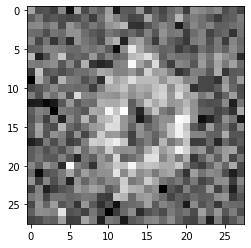

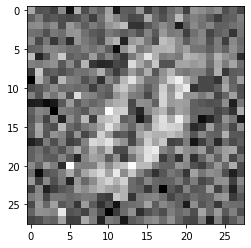

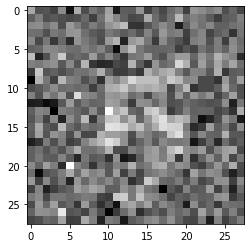

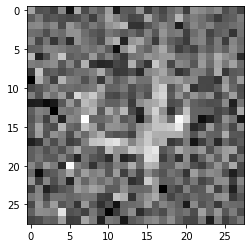

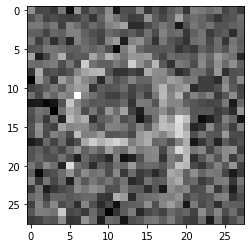

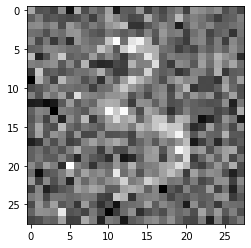

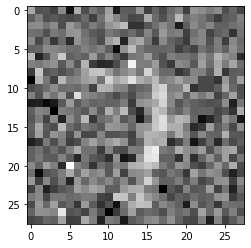

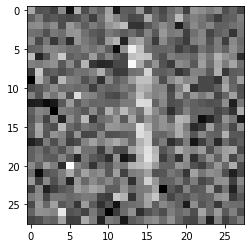

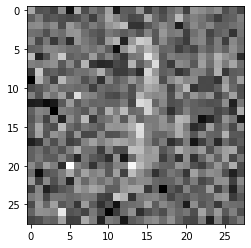

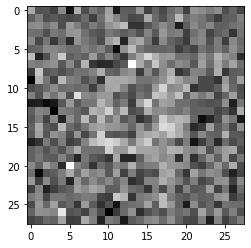

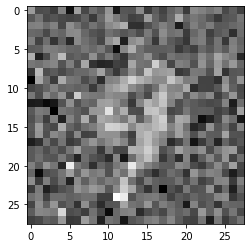

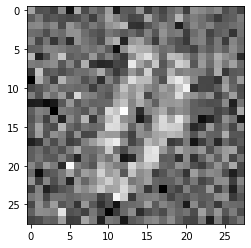

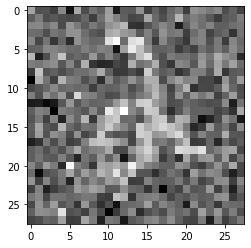

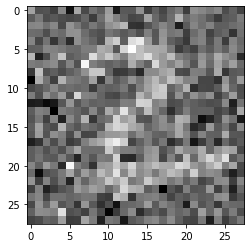

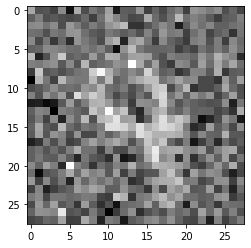

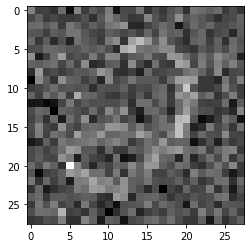

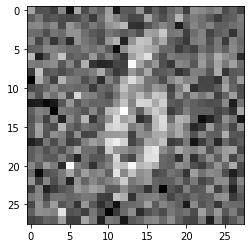

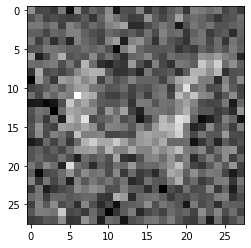

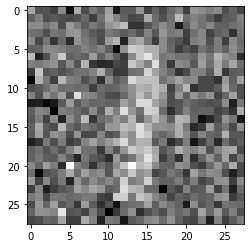

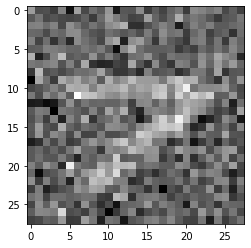

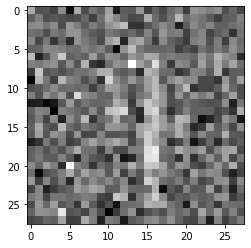

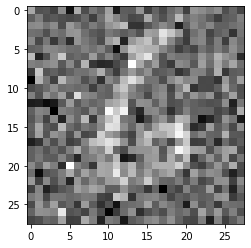

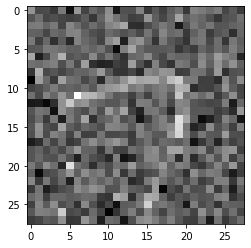

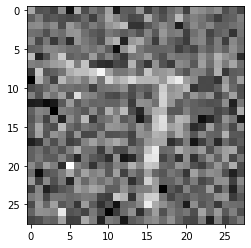

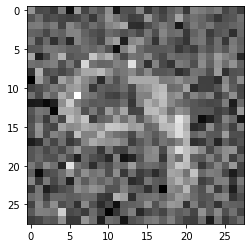

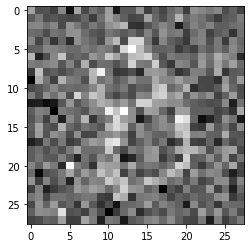

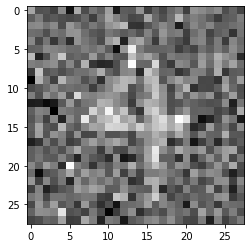

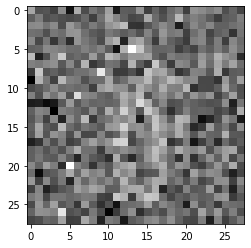

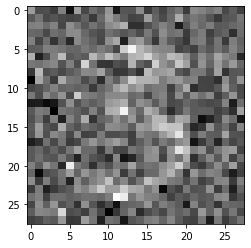

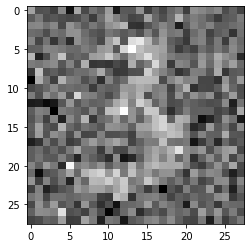

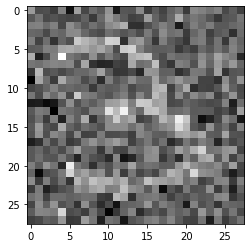

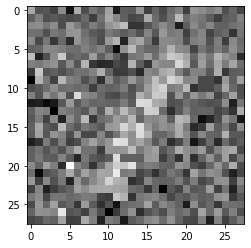

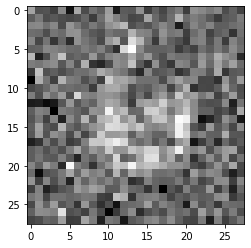

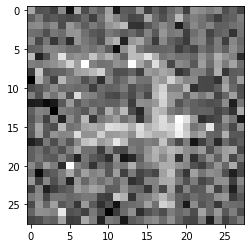

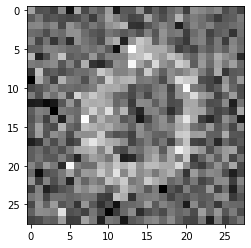

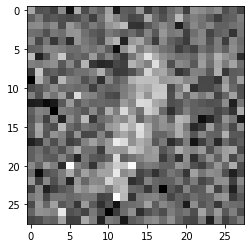

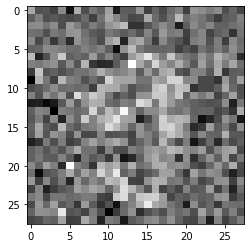

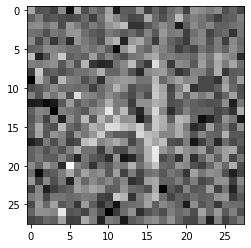

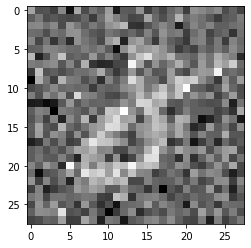

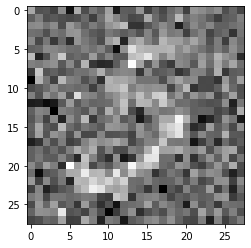

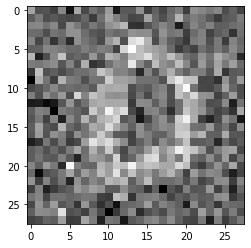

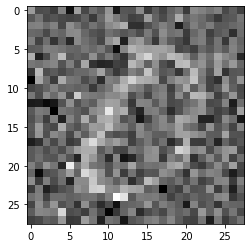

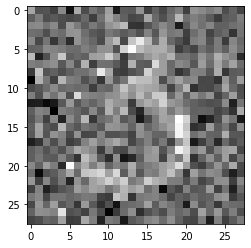

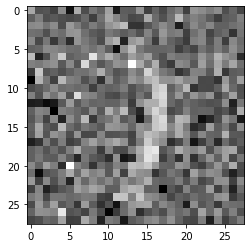

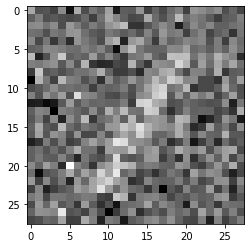

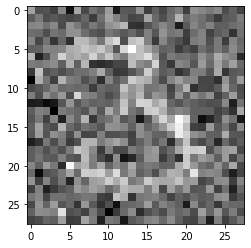

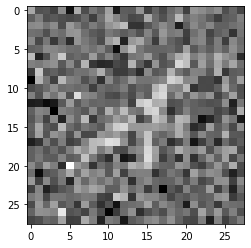

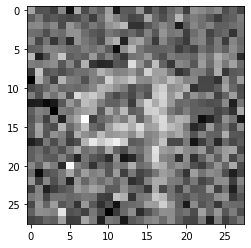

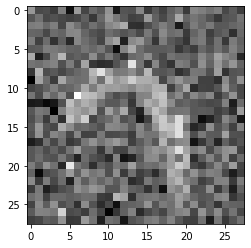

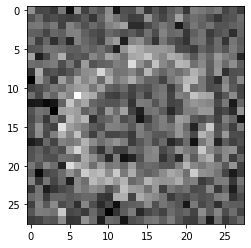

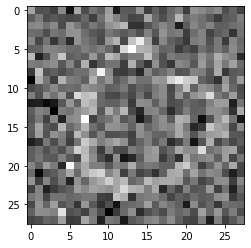

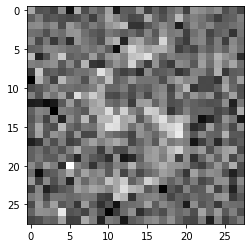

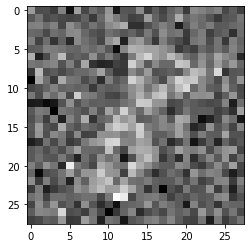

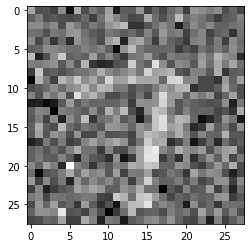

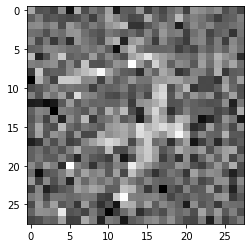

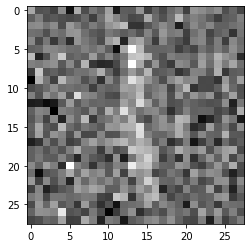

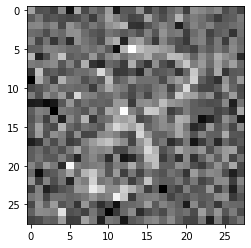

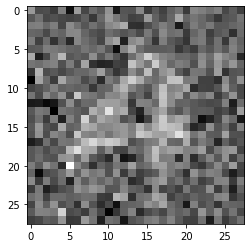

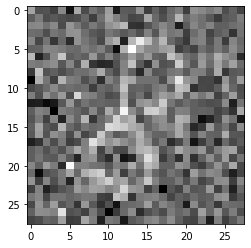

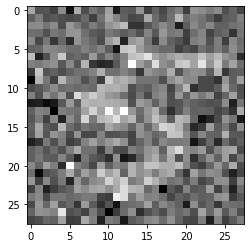

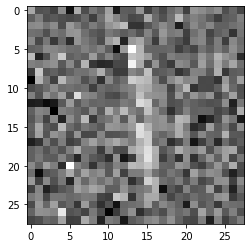

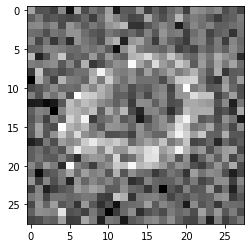

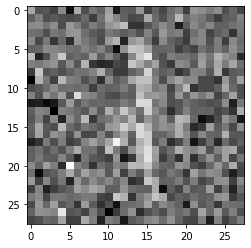

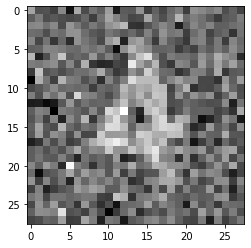

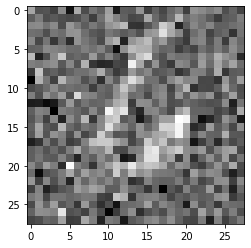

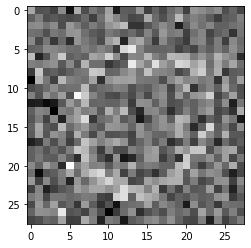

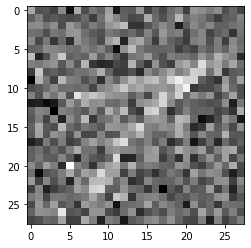

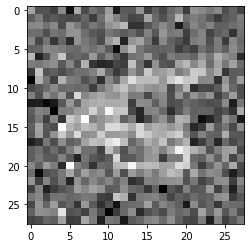

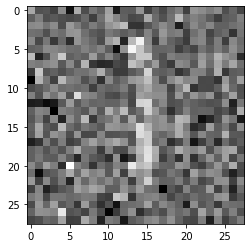

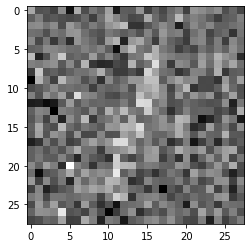

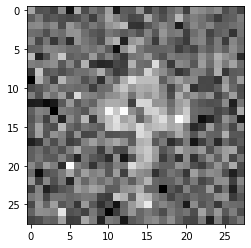

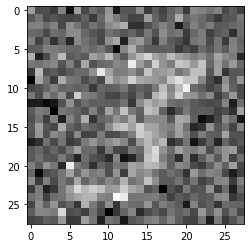

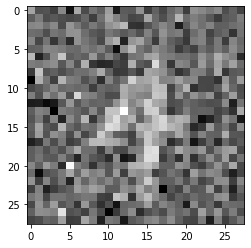

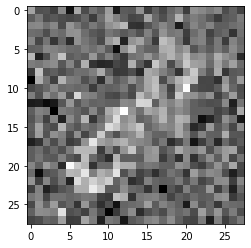

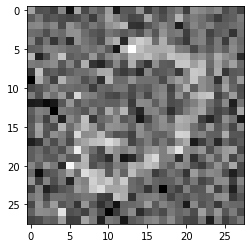

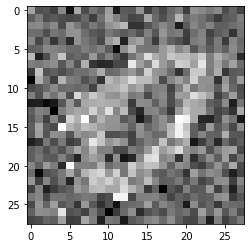

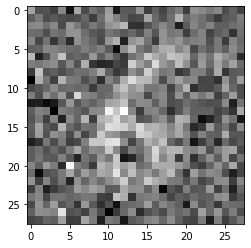

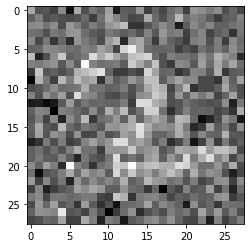

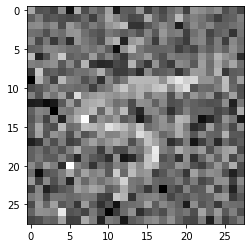

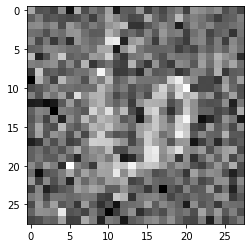

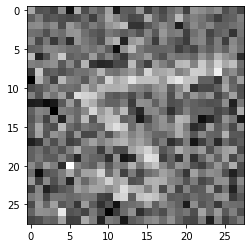

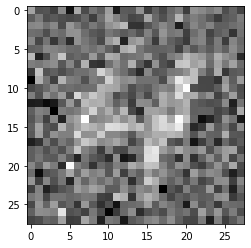

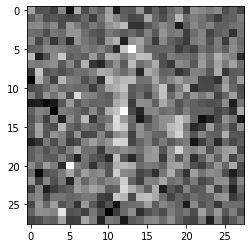

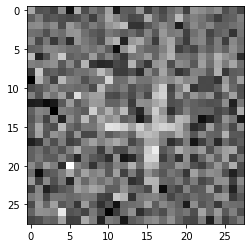

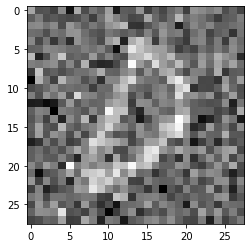

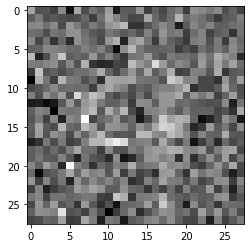

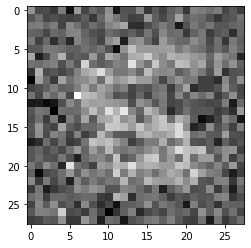

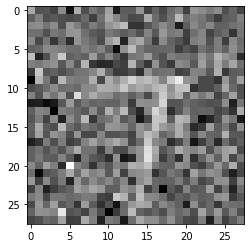

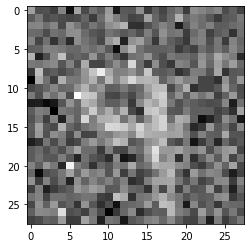

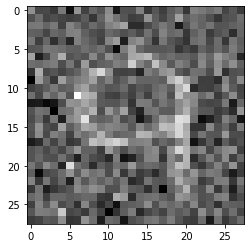

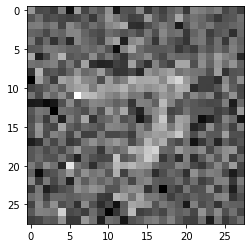

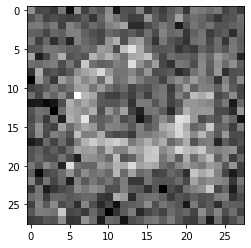

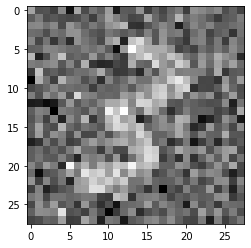

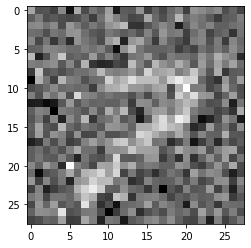

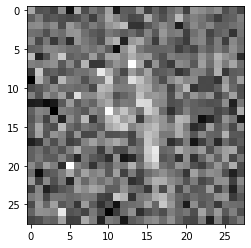

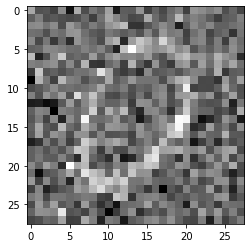

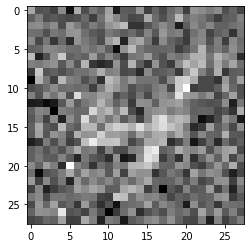

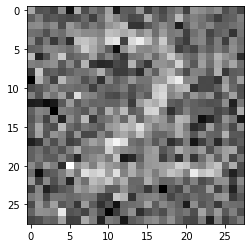

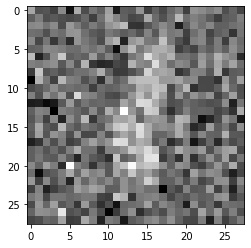

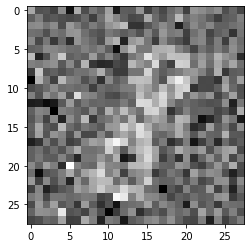

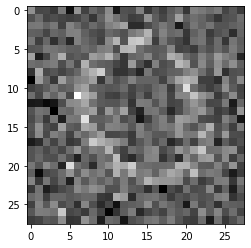

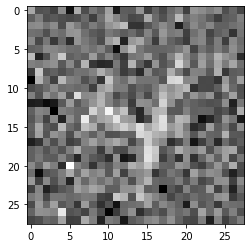

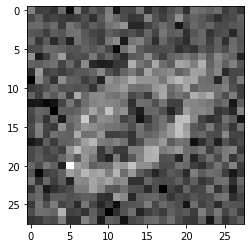

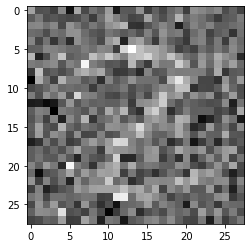

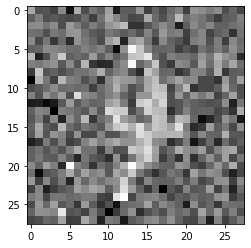

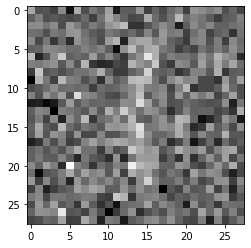

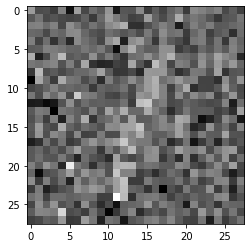

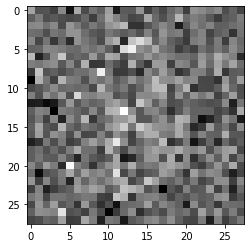

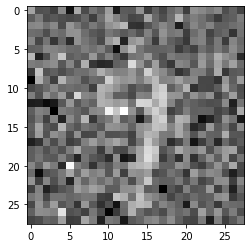

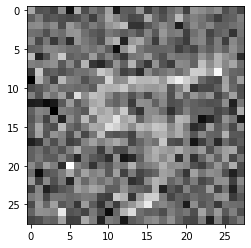

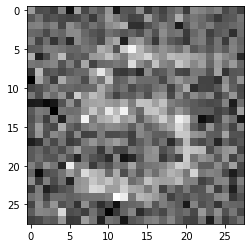

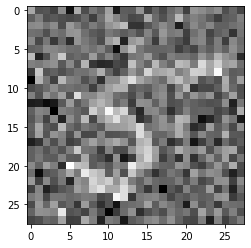

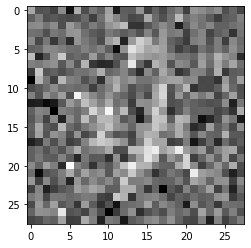

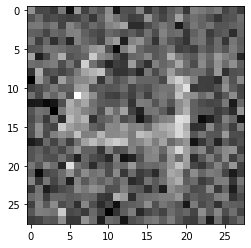

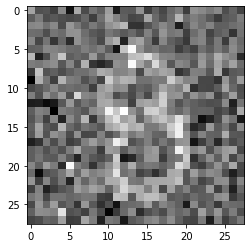

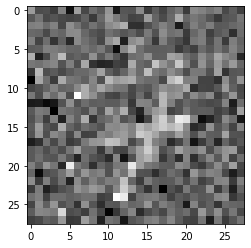

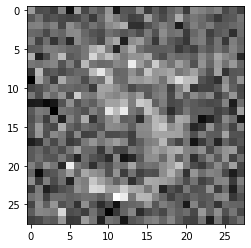

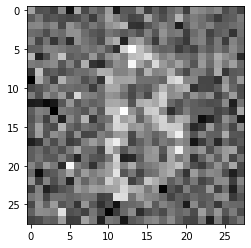

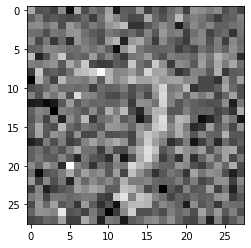

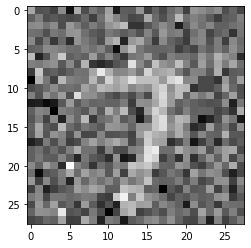

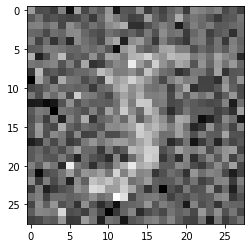

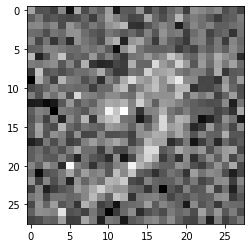

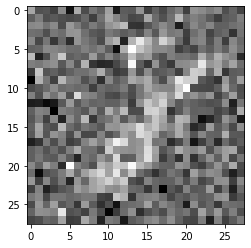

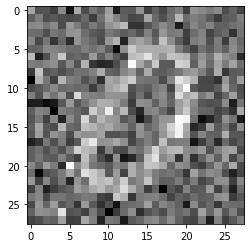

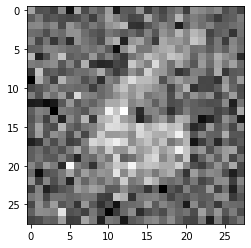

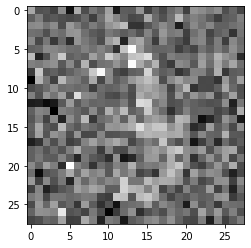

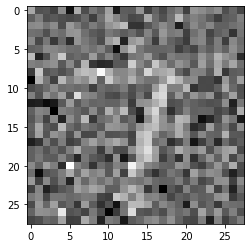

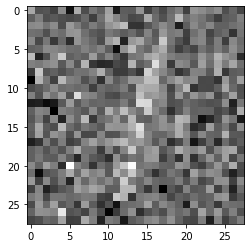

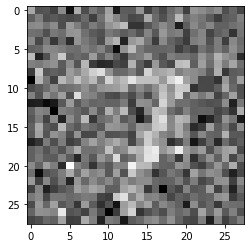

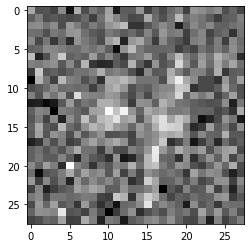

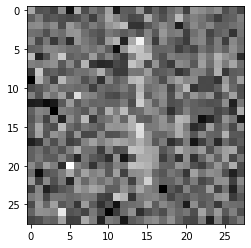

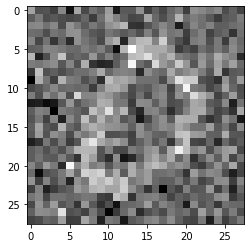

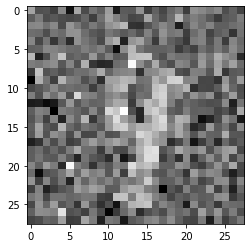

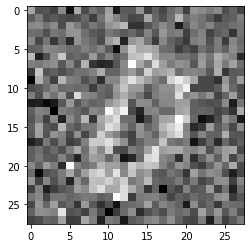

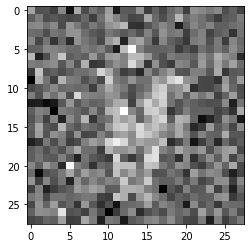

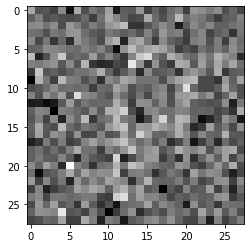

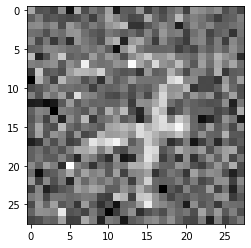

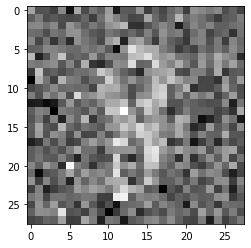

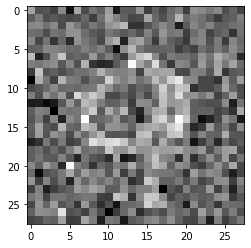

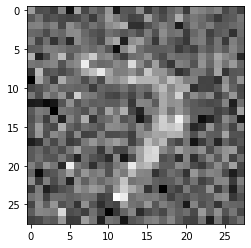

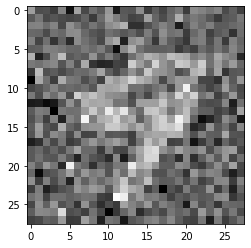

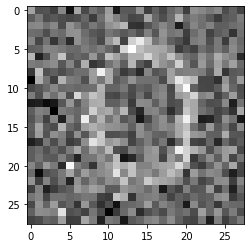

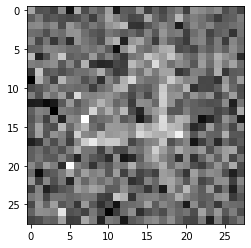

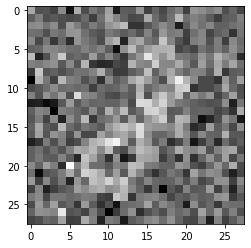

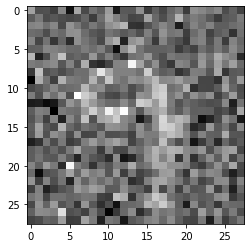

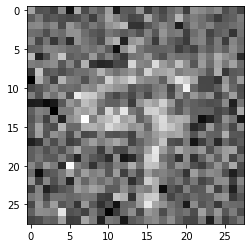

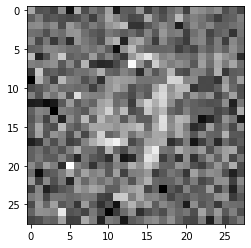

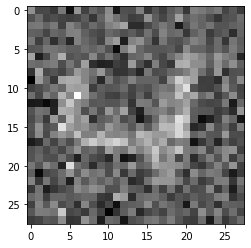

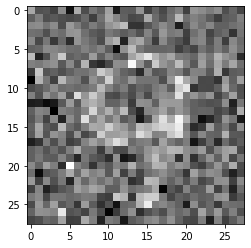

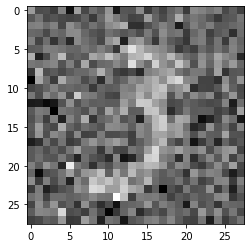

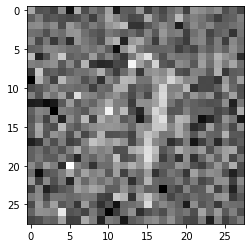

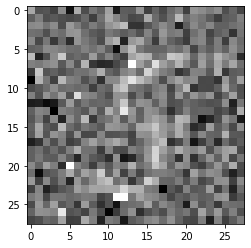

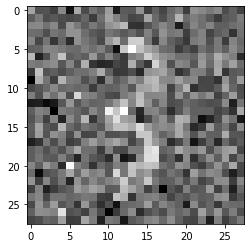

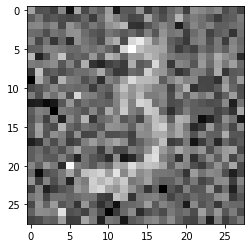

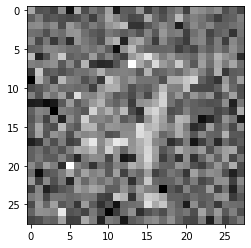

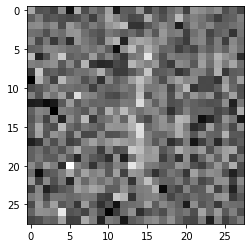

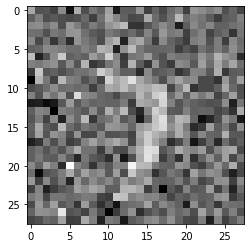

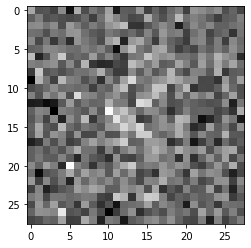

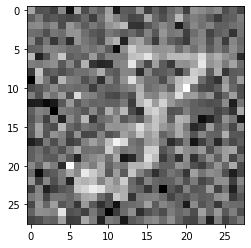

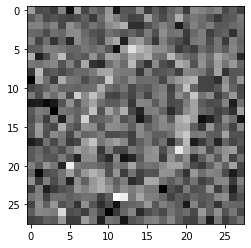

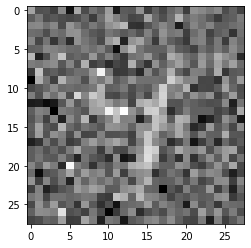

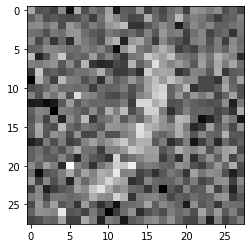

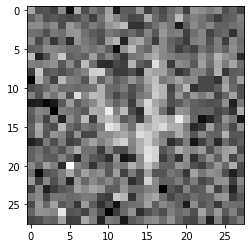

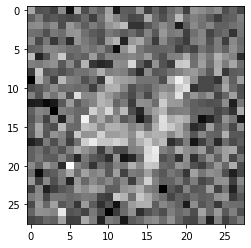

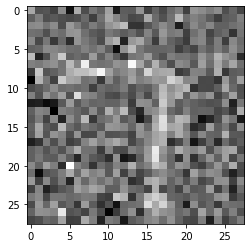

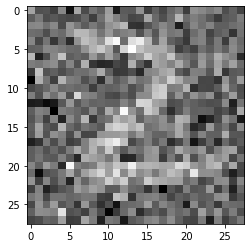

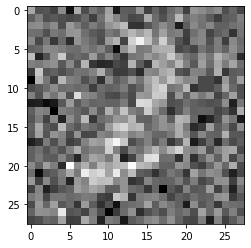

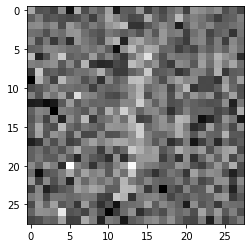

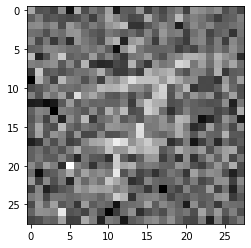

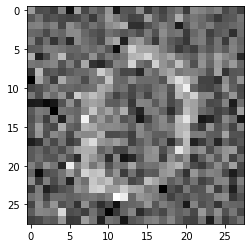

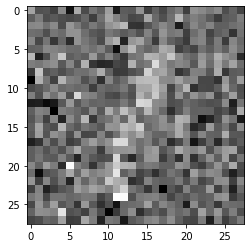

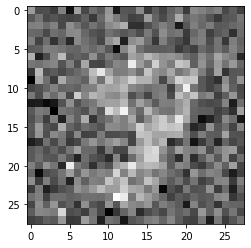

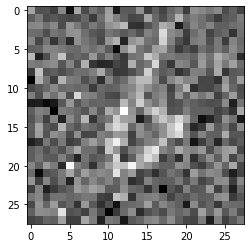

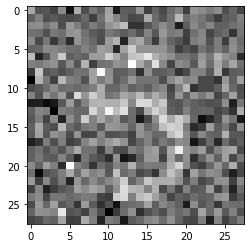

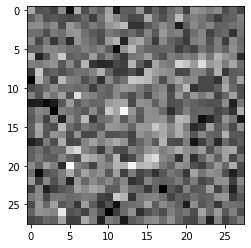

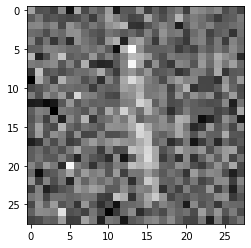

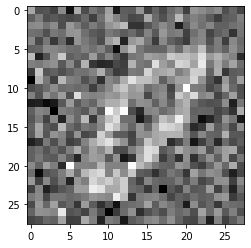

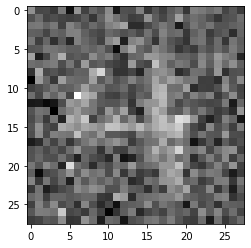

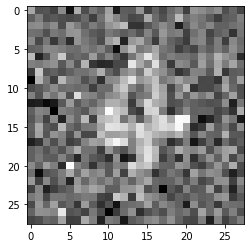

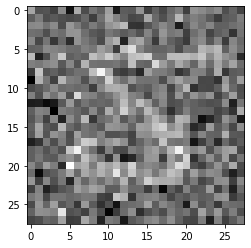

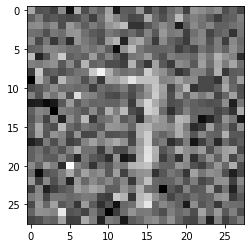

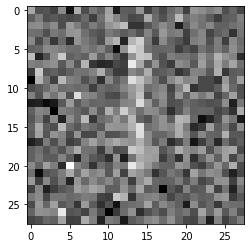

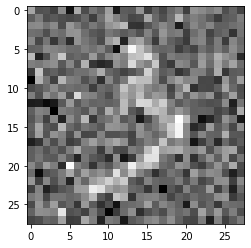

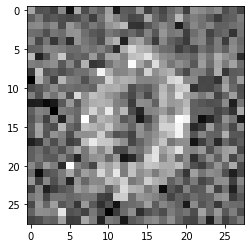

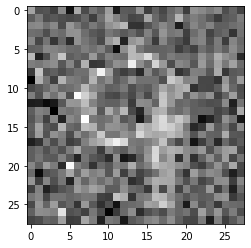

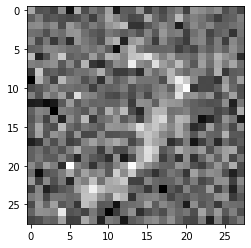

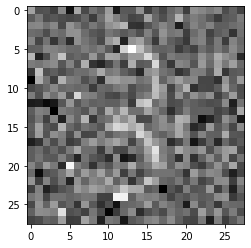

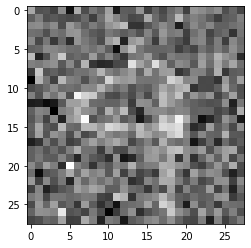

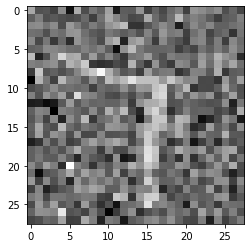

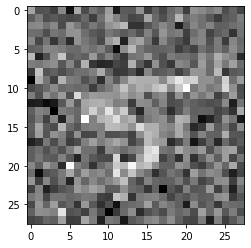

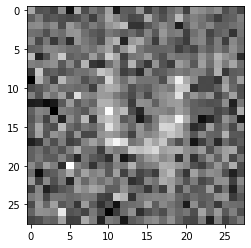

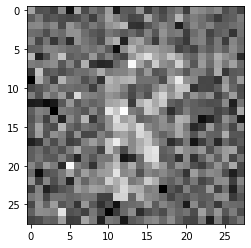

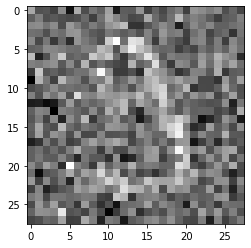

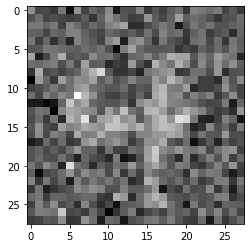

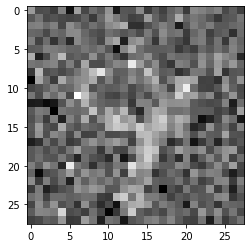

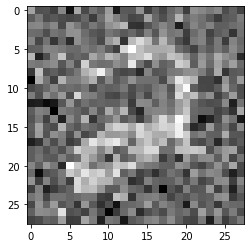

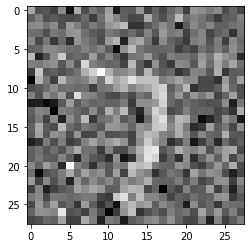

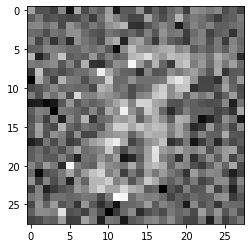

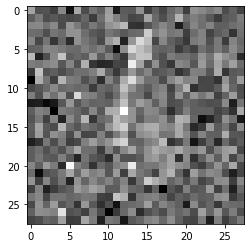

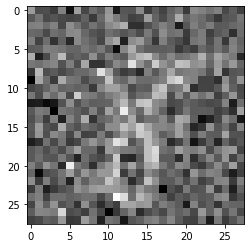

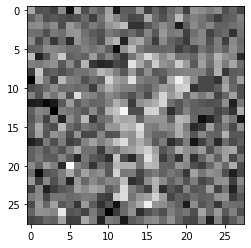

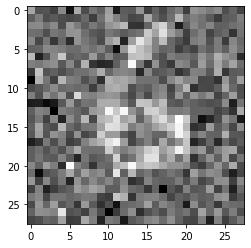

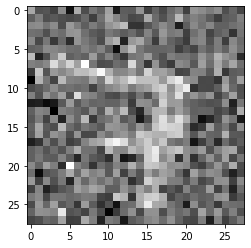

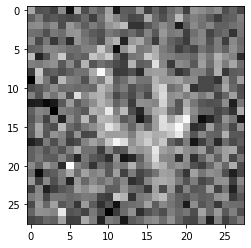

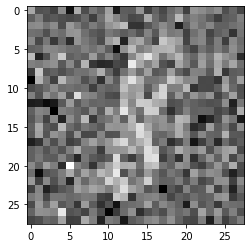

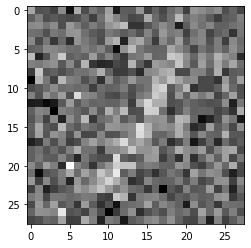

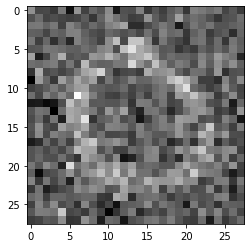

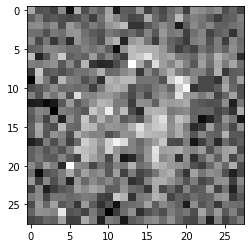

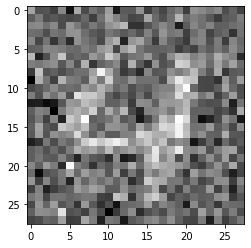

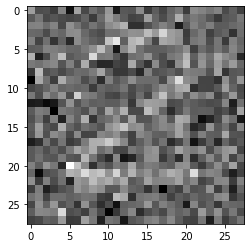

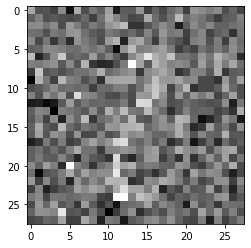

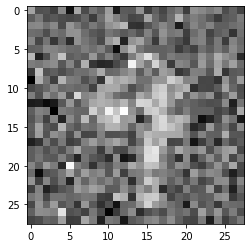

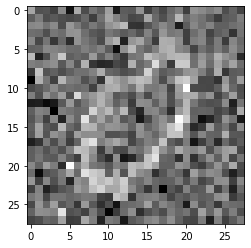

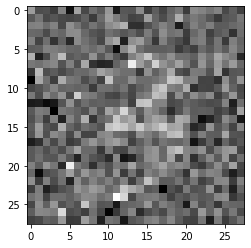

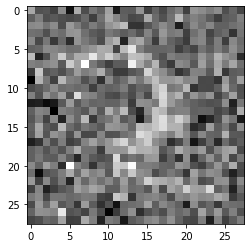

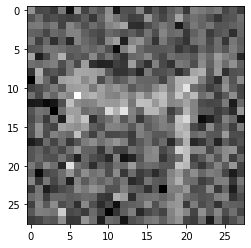

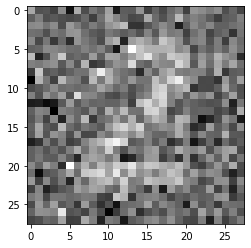

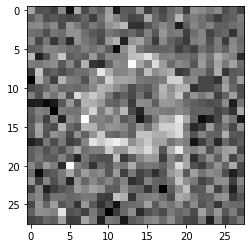

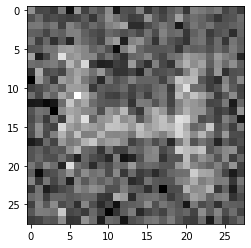

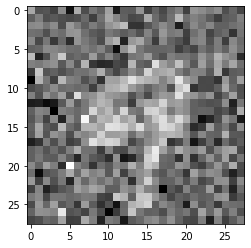

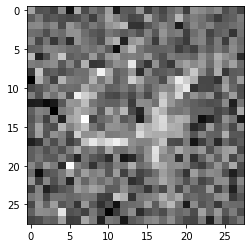

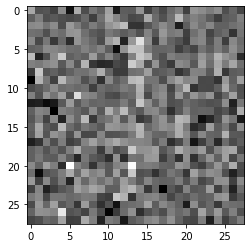

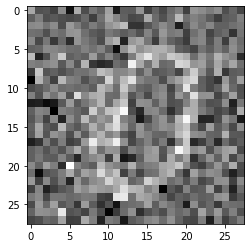

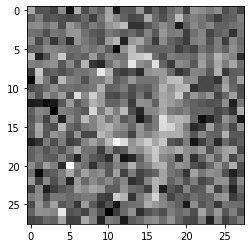

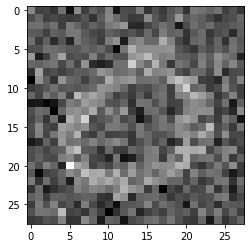

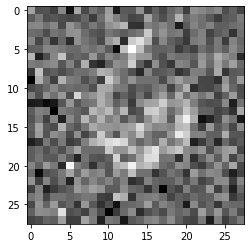

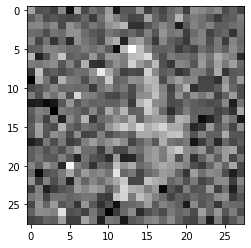

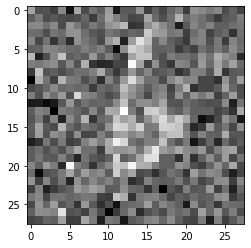

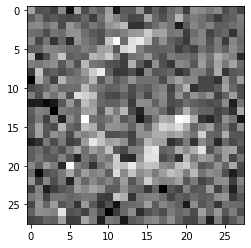

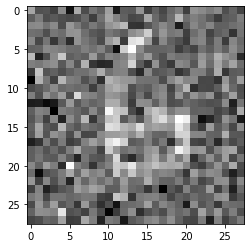

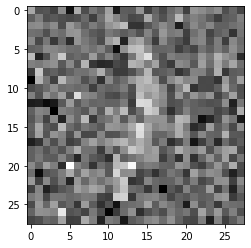

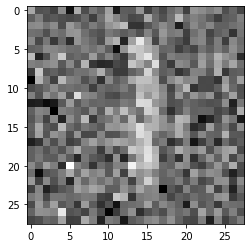

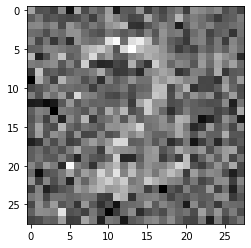

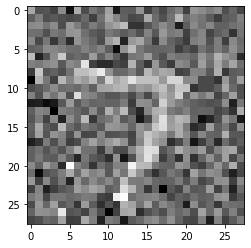

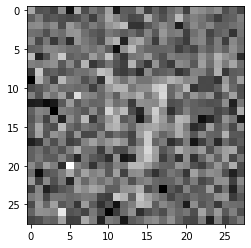

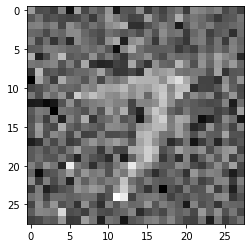

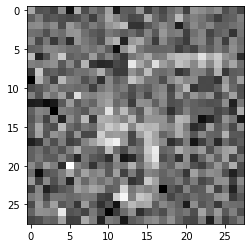

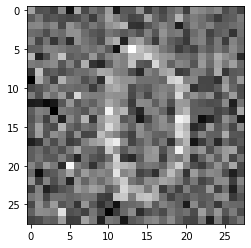

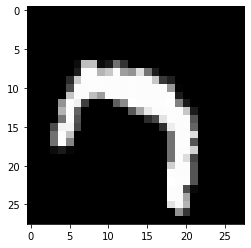

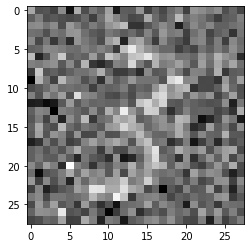

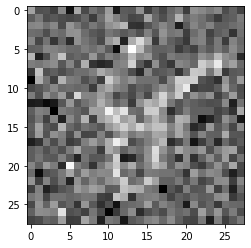

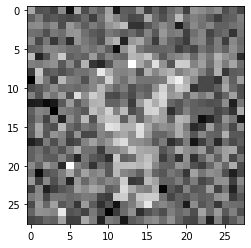

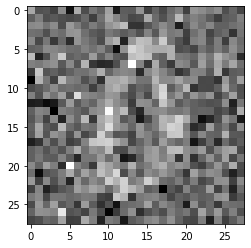

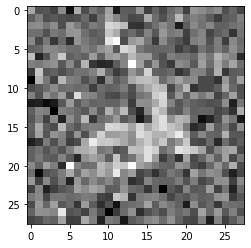

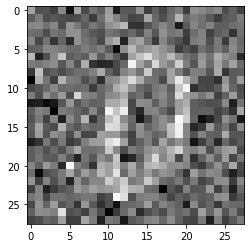

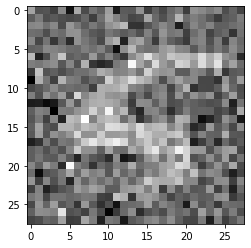

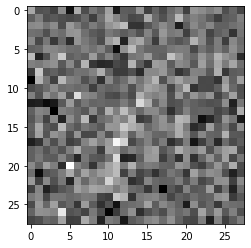

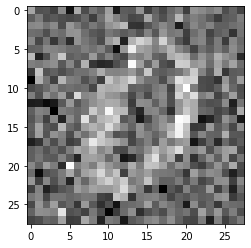

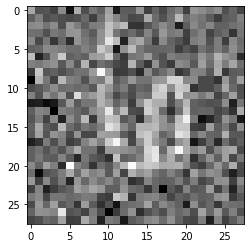

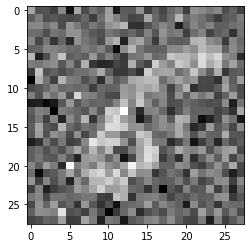

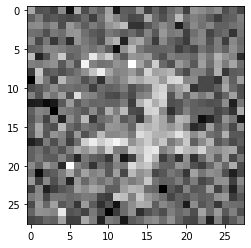

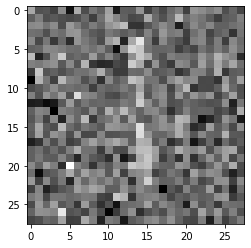

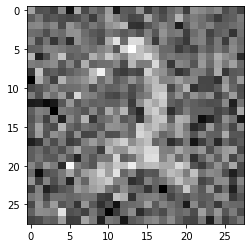

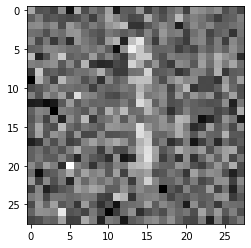

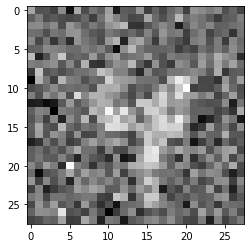

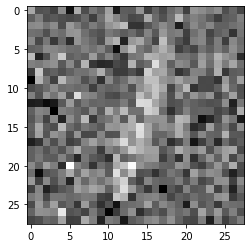

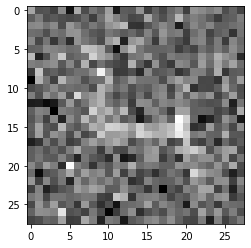

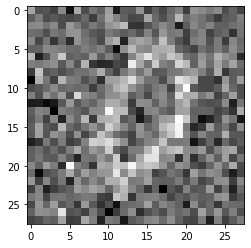

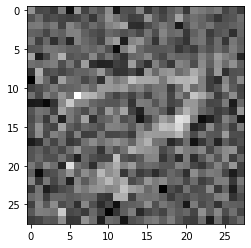

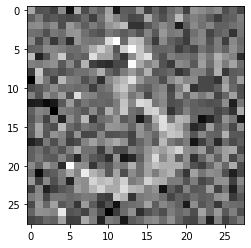

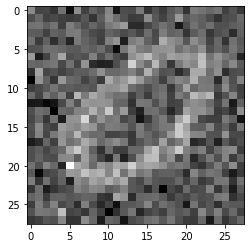

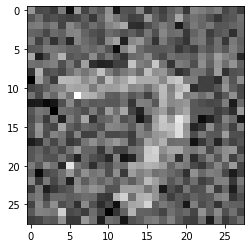

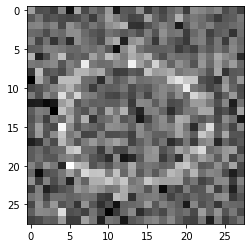

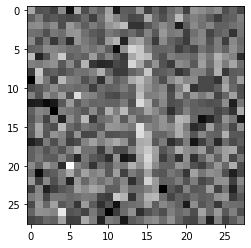

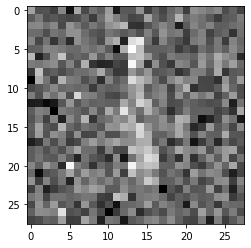

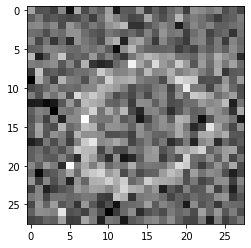

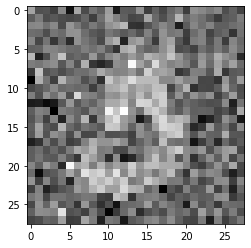

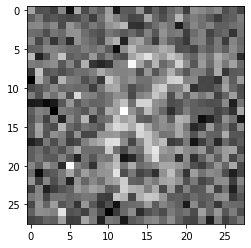

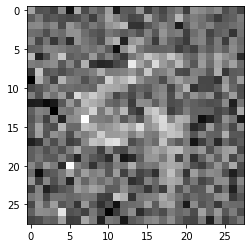

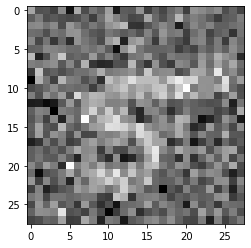

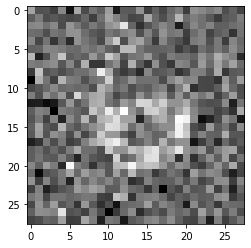

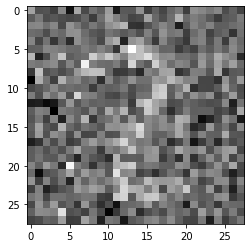

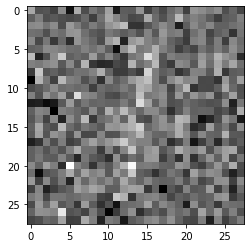

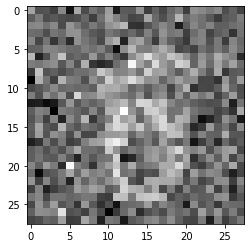

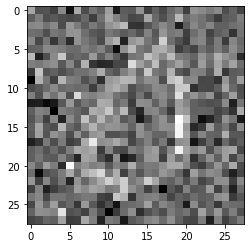

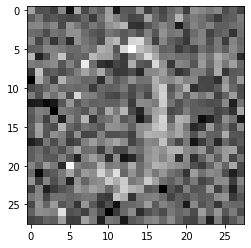

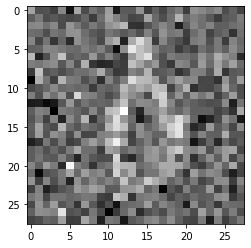

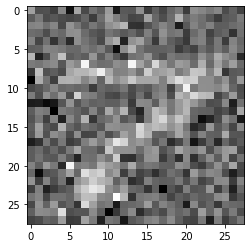

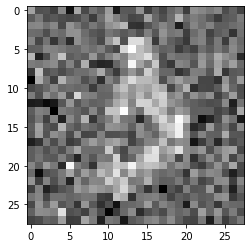

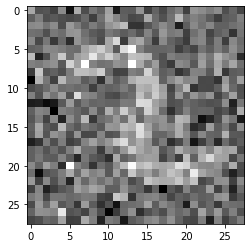

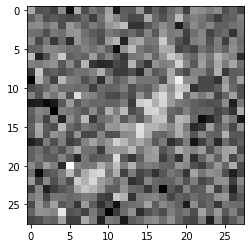

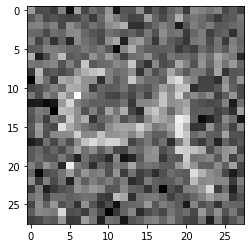

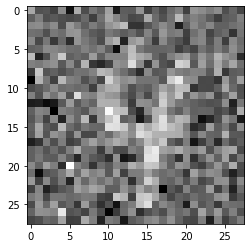

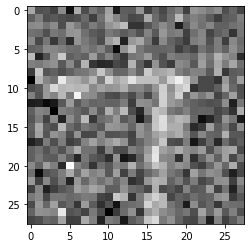

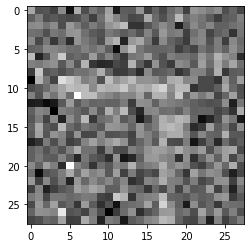

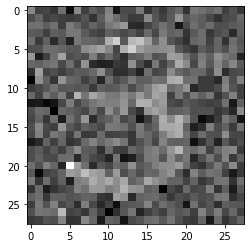

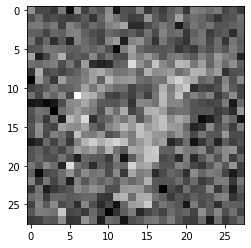

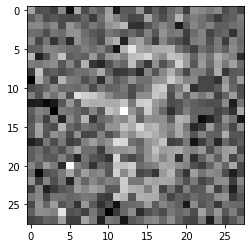

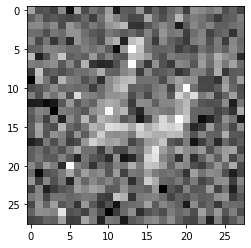

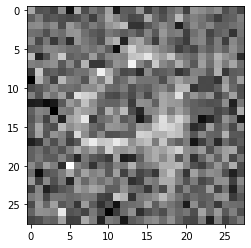

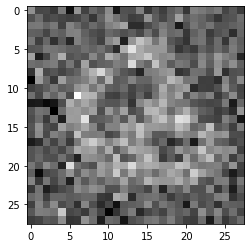

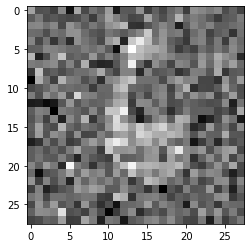

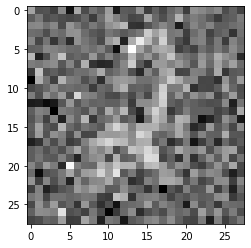

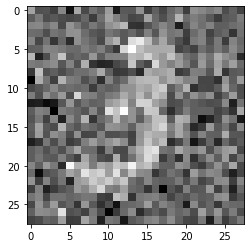

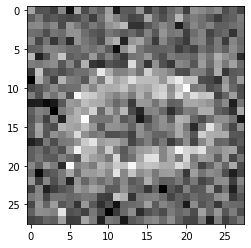

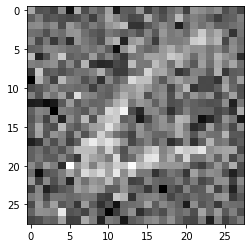

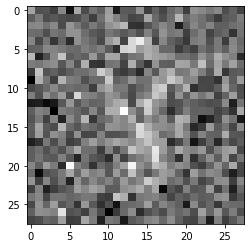

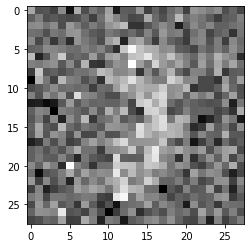

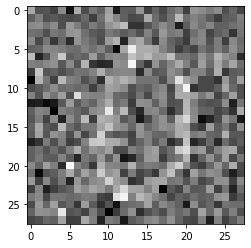

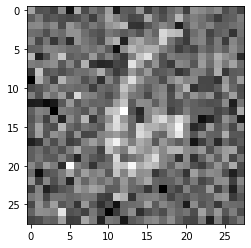

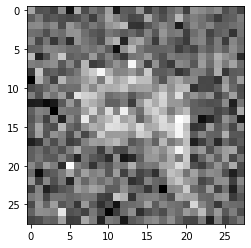

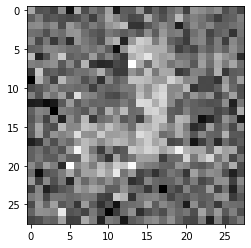

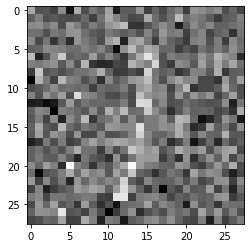

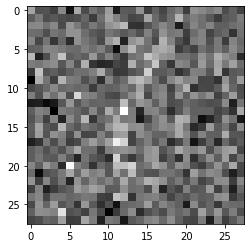

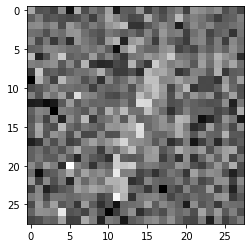

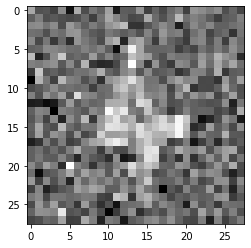

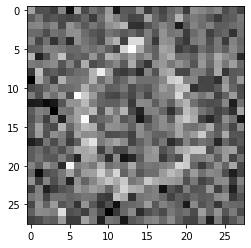

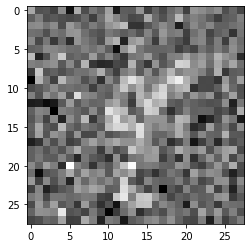

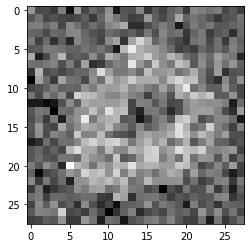

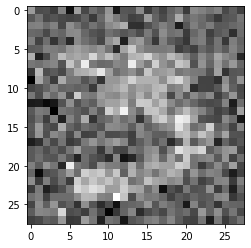

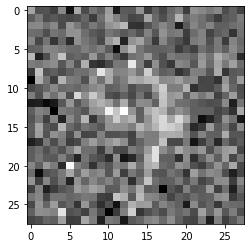

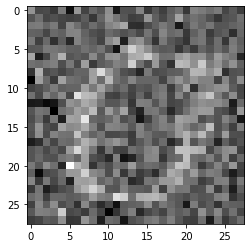

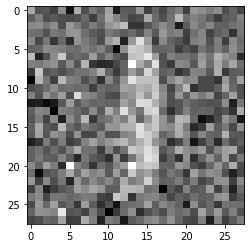

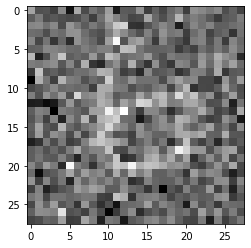

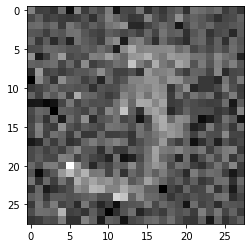

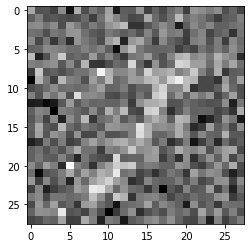

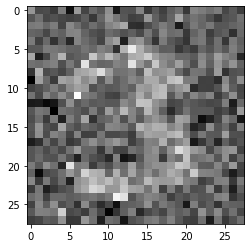

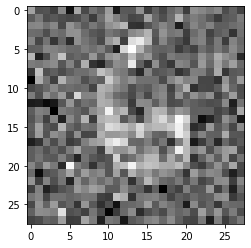

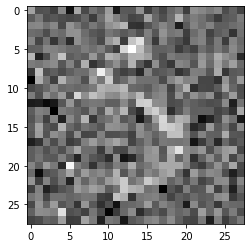

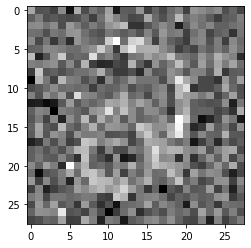

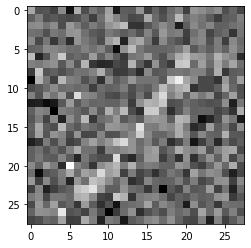

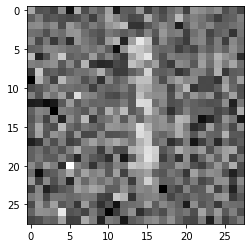

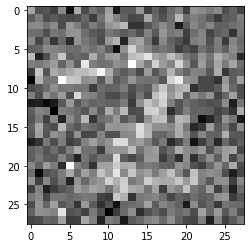

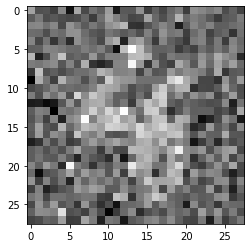

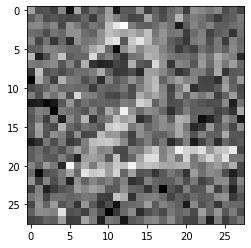

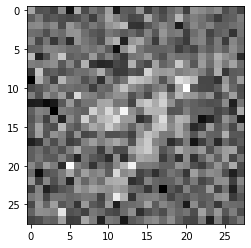

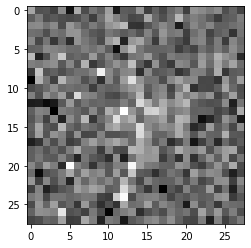

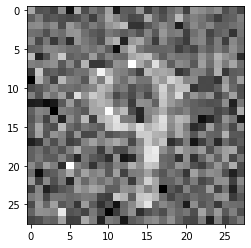

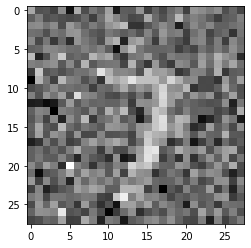

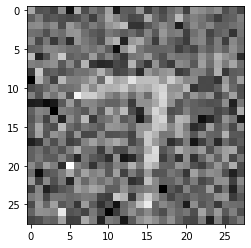

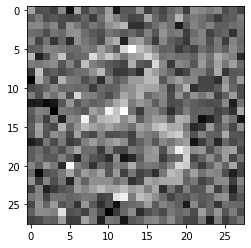

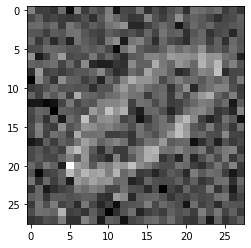

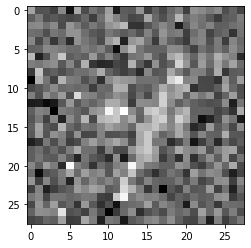

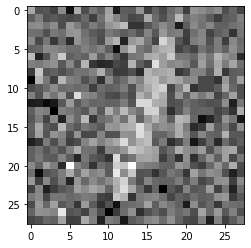

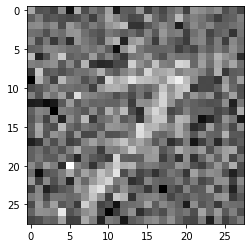

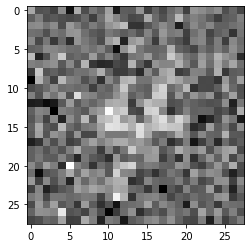

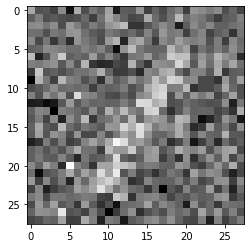

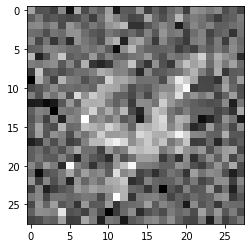

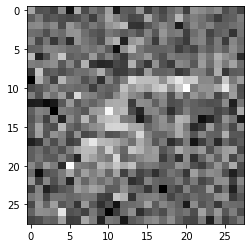

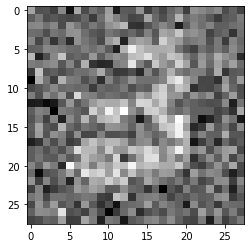

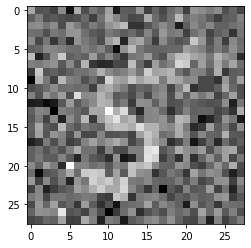

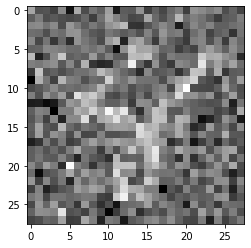

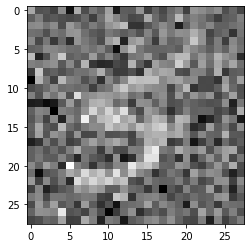

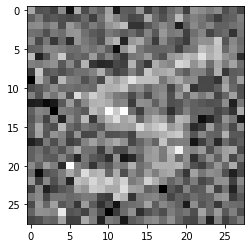

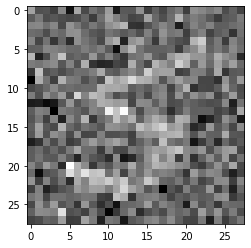

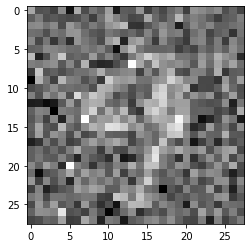

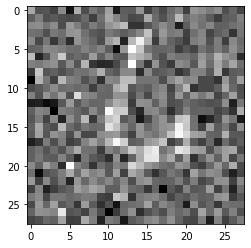

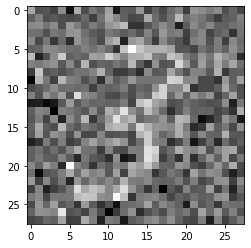

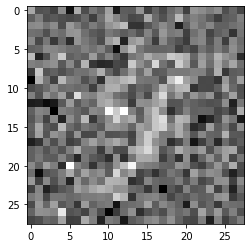

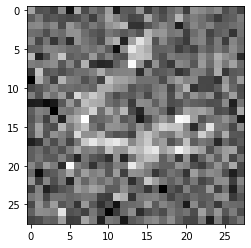

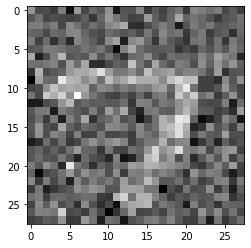

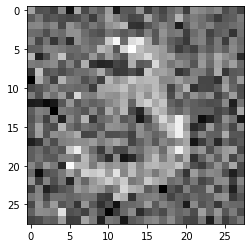

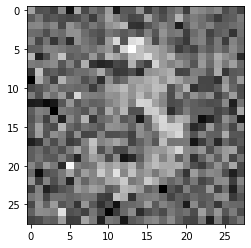

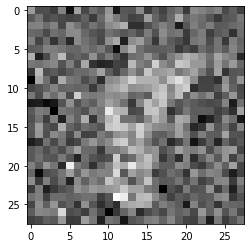

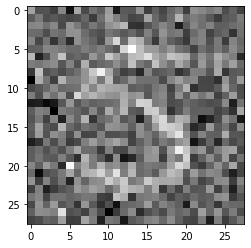

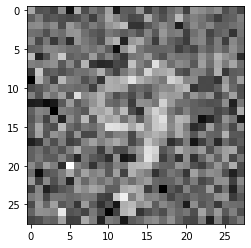

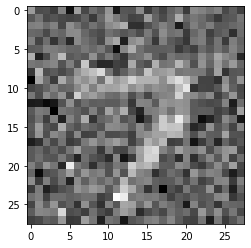

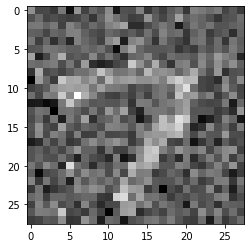

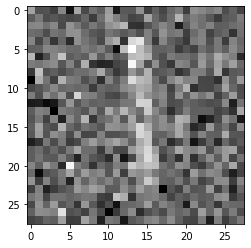

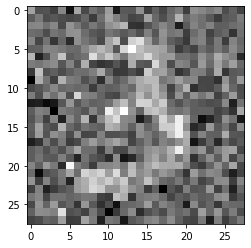

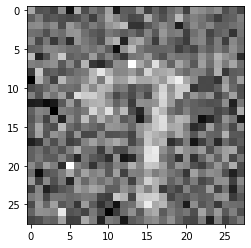

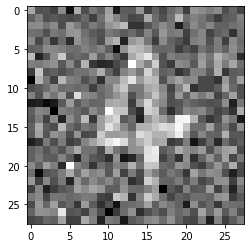

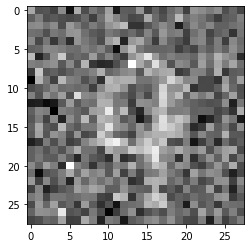

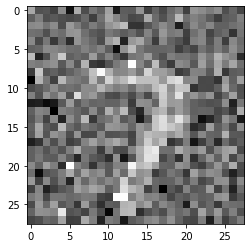

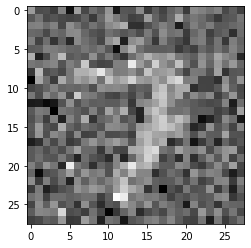

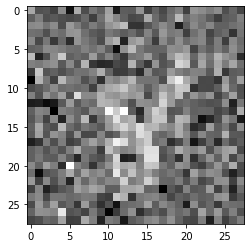

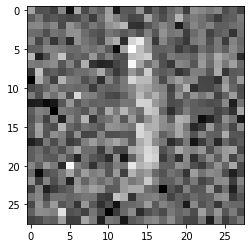

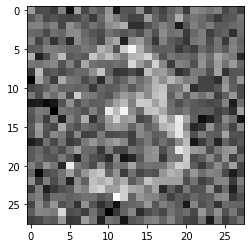

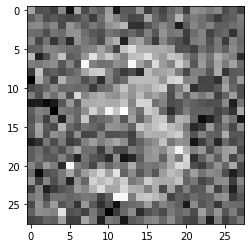

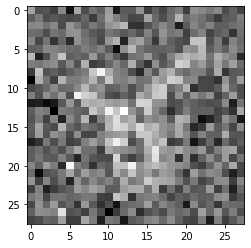

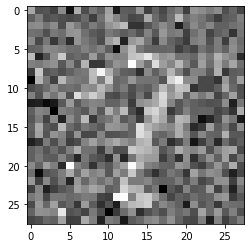

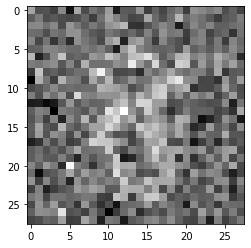

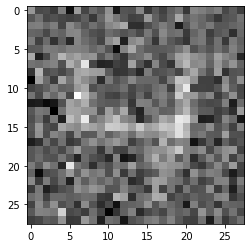

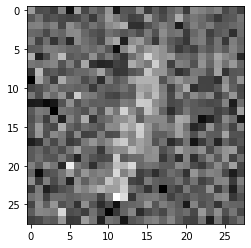

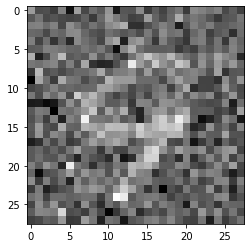

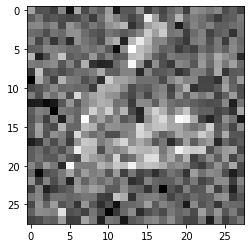

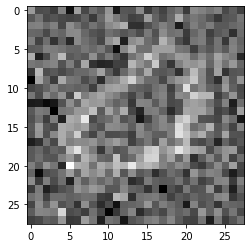

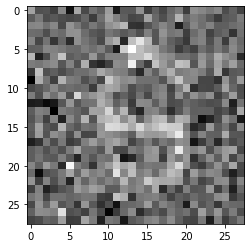

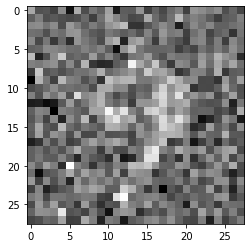

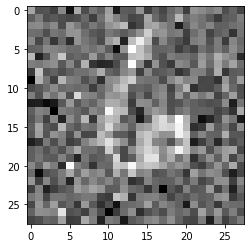

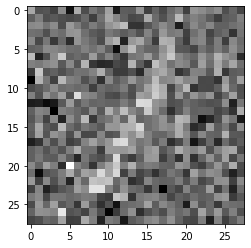

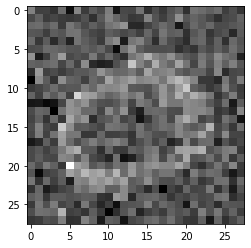

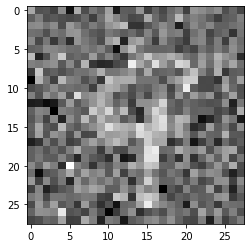

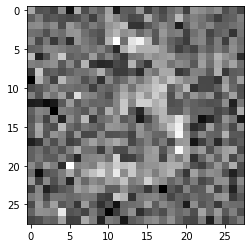

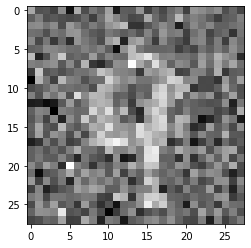

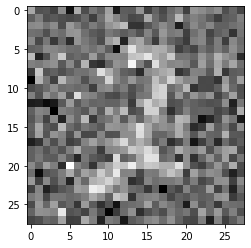

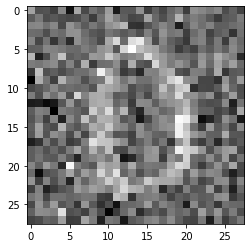

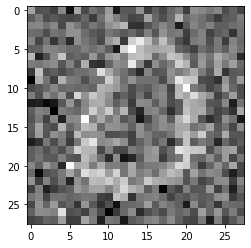

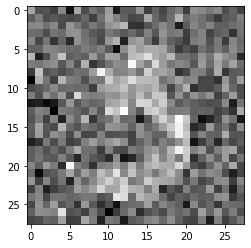

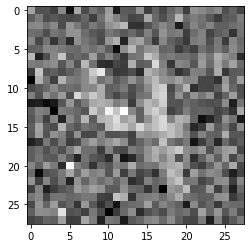

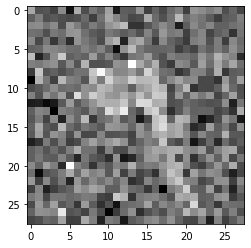

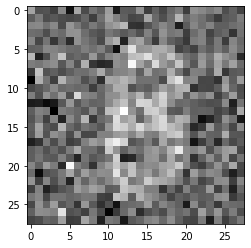

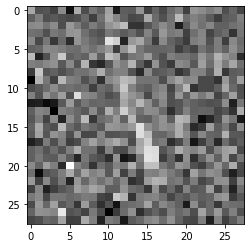

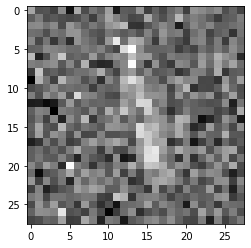

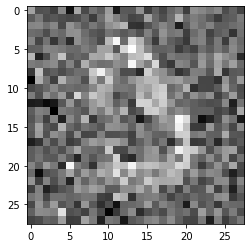

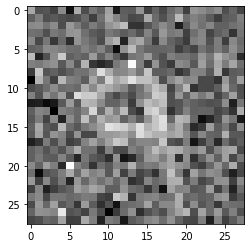

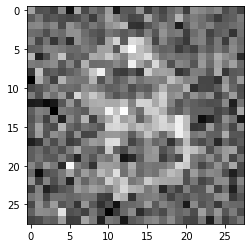

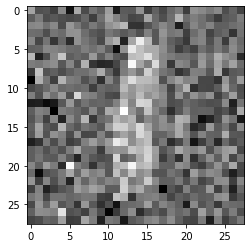

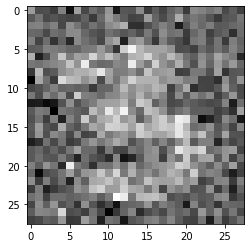

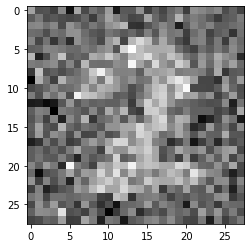

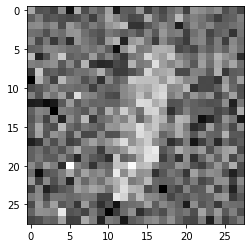

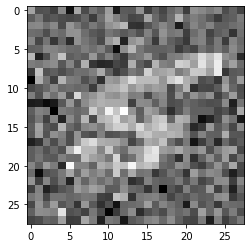

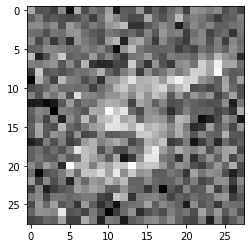

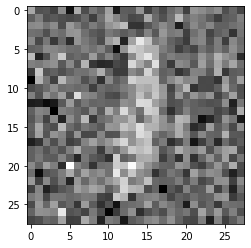

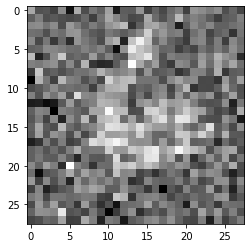

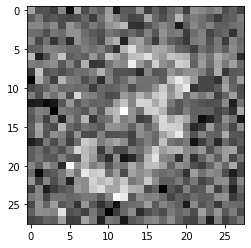

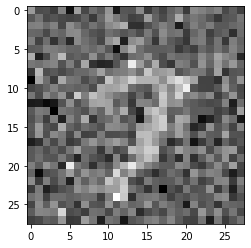

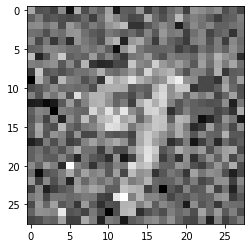

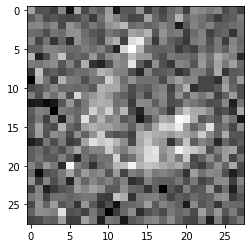

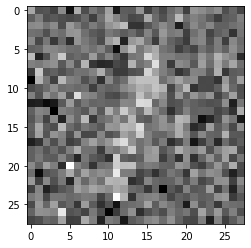

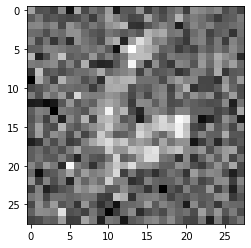

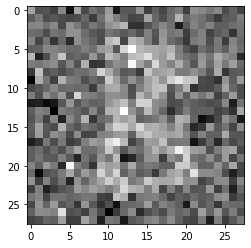

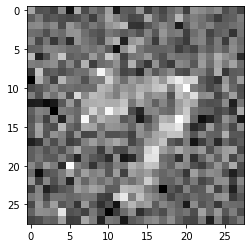

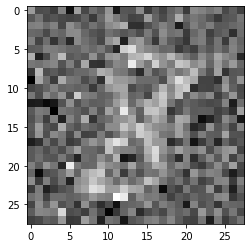

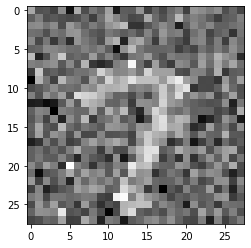

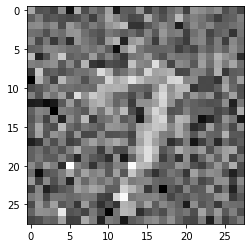

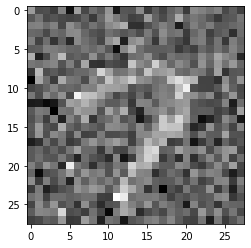

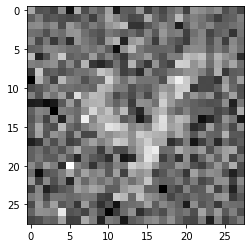

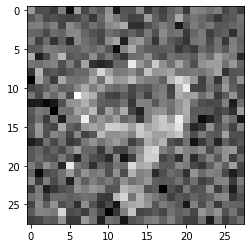

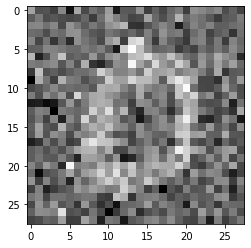

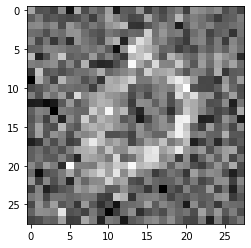

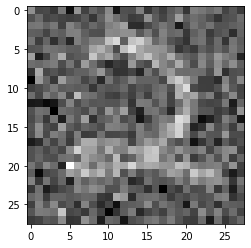

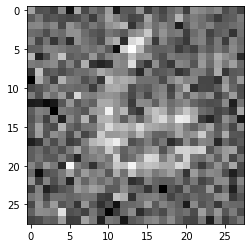

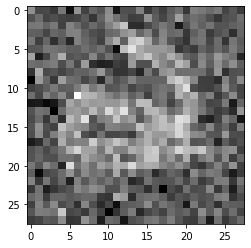

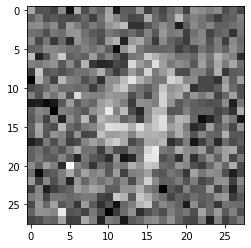

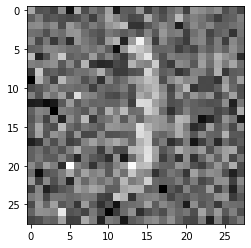

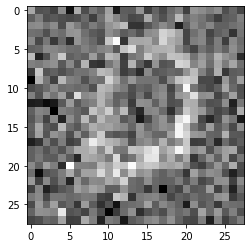

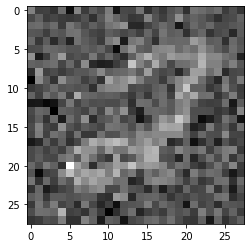

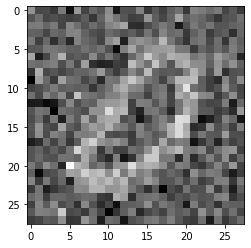

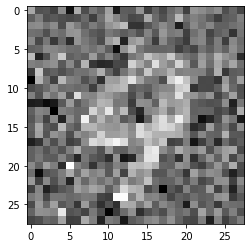

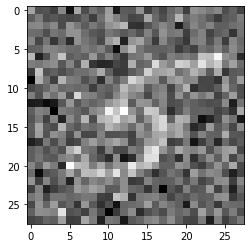

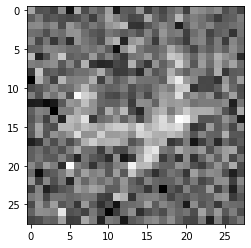

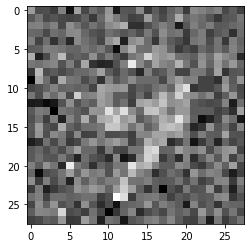

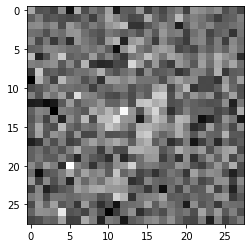

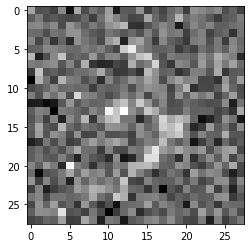

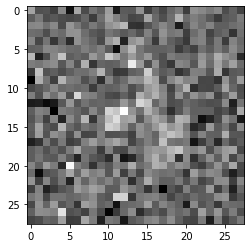

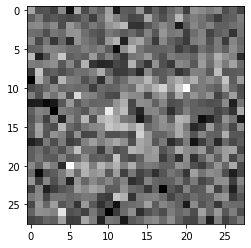

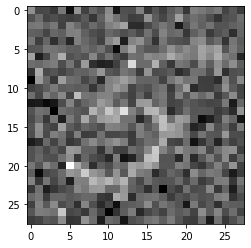

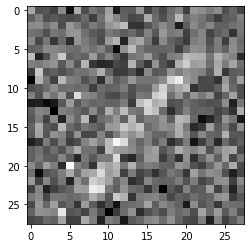

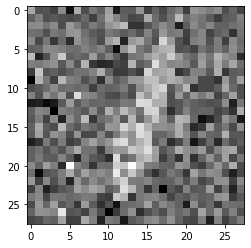

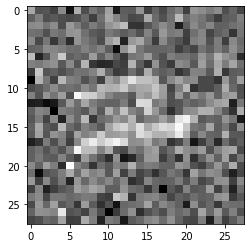

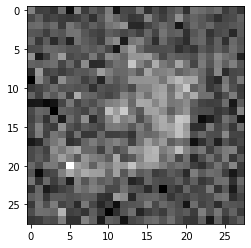

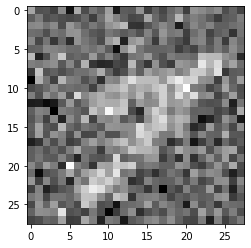

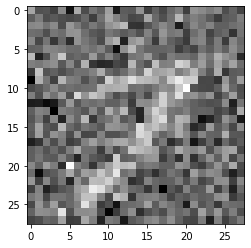

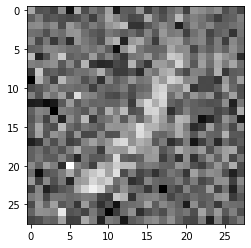

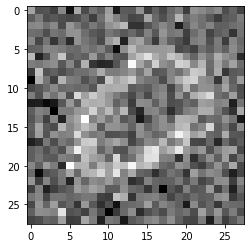

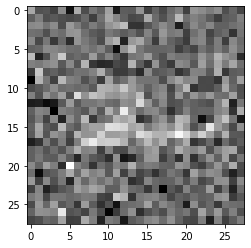

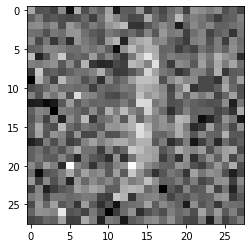

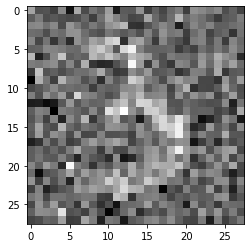

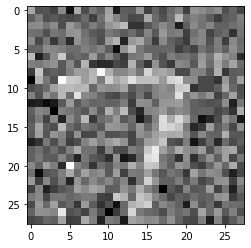

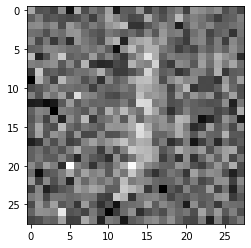

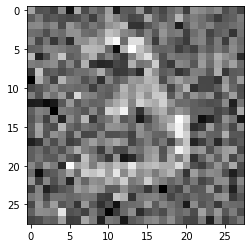

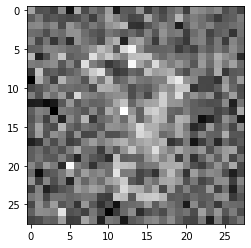

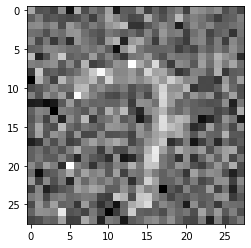

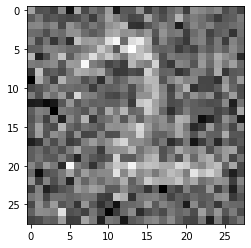

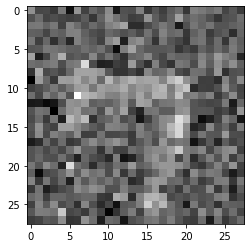

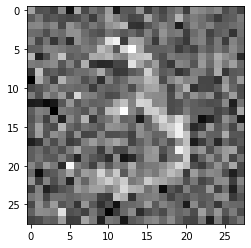

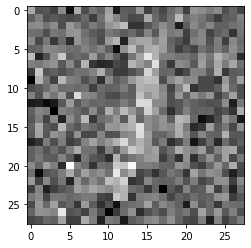

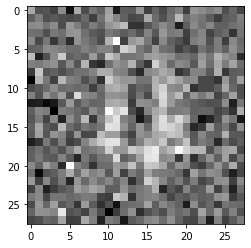

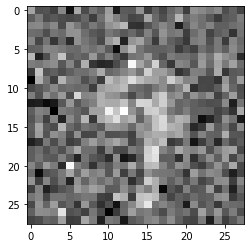

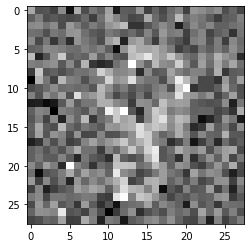

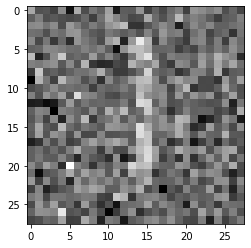

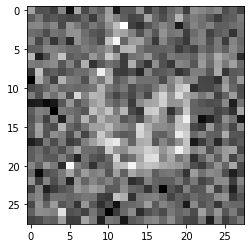

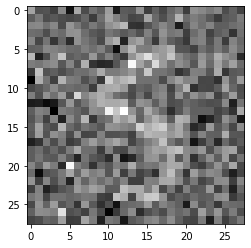

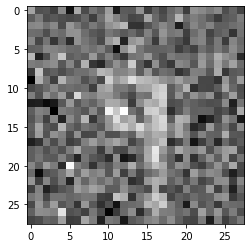

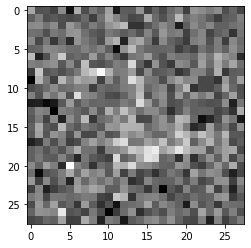

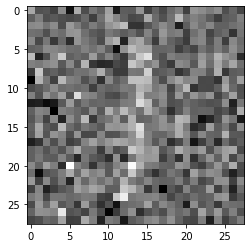

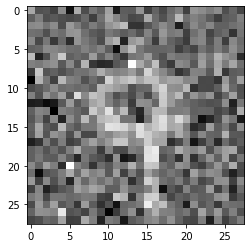

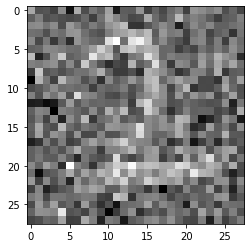

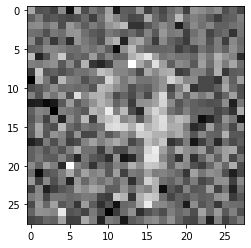

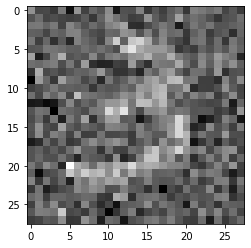

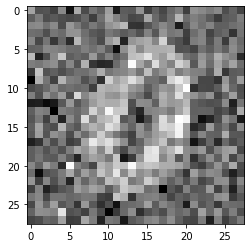

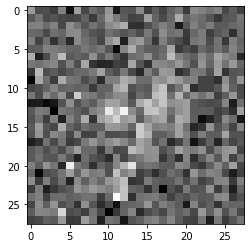

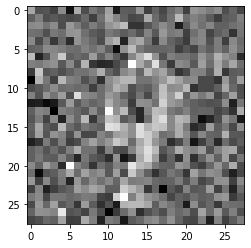

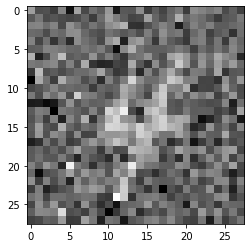

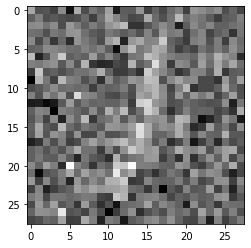

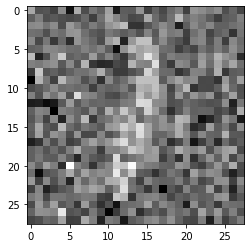

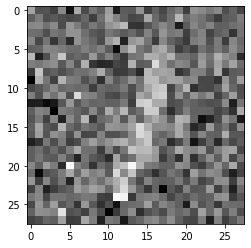

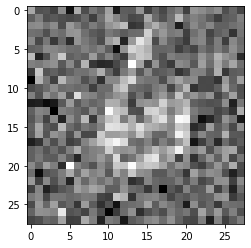

KeyboardInterrupt: 

In [35]:
for idx in del_idx:
    plot_sample(X_test, idx)

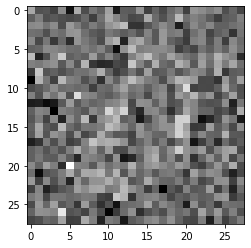

In [37]:
def add_noise_to_sample(img):
    noise = np.zeros(img.shape)
    noise = noise.flatten()

    noise = noise + np.random.RandomState(seed=1).normal(0,1, len(noise))

    noise = noise.reshape(img.shape)
    
    return img + noise

noise_indices_test = np.random.RandomState(seed=1).permutation(len(X_test))[0:len(X_test)//10]
noise_indices_train = np.random.RandomState(seed=1).permutation(len(X_train_full))[0:len(X_train_full)//10]
for n in noise_indices:
    X_test[n] = add_noise_to_sample(X_test[n])
    X_train_full[n] = add_noise_to_sample(X_train_full[n])
plot_sample(X_test, noise_indices[-1])